In [1]:
import pandas as pd
import numpy as np
import torch
import os
import pickle

from fairseq_signals.data.ecg.raw_ecg_dataset import FileECGDataset, NpECGDataset, DataframeECGDataset
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, f1_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torchmetrics.functional.classification as Fc

from scipy.stats import spearmanr, linregress, pearsonr
from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm 
import functools


/root/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def try_catch_fn(fn, default_val=np.nan):
    try:
        result = fn()
        # Convert tensor to a scalar if applicable
        if isinstance(result, torch.Tensor):
            return result.item()
        return result
    except Exception as e:
        print('Error occurred when evaluating metrics:', e)
        return default_val

def stable_sigmoid(x):
    x_safe = np.clip(x, -500, 500)
    return np.where(x_safe >= 0,
                    1 / (1 + np.exp(-x_safe)),
                    np.exp(x_safe) / (1 + np.exp(x_safe)))

def find_optimal_threshold_youden_index_multilabel(true_labels, pred_scores):
    optimal_thresholds = []
    youden_indices = []

    for i in range(true_labels.shape[1]):
        fpr, tpr, thresholds = roc_curve(true_labels[:, i], pred_scores[:, i])
        youden_index = tpr - fpr
        optimal_idx = np.argmax(youden_index)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)
        youden_indices.append(youden_index[optimal_idx])

    return np.array(optimal_thresholds), np.array(youden_indices)

def calculate_permuted_metrics(y_true, y_pred, device, y_labels, categories, num_permutations=100, sample_ratio=0.8, youden_threshold=False):
    permuted_scores = {}

    for perm in tqdm(range(num_permutations), desc="Calculating Permutations"):
        # Sample 80% of data
        indices = np.random.choice(len(y_true), int(len(y_true) * sample_ratio), replace=False)
        
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        
        # Calculate metrics on the sample

        metrics = calculate_metrics(y_true_sample, y_pred_sample, device, y_labels, categories, youden_threshold=youden_threshold)

        # Collect results for each metric
        for metric_key, metric_value in metrics.get("tm", {}).items():
            # Only collect category-level metrics, not individual y_labels
            if any(category in metric_key for category in categories) or any(y_label in metric_key for y_label in y_labels):
                if isinstance(metric_value, (float, int)):
                    permuted_scores.setdefault(metric_key, []).append(metric_value)
                else:
                    print(f"Warning: Metric {metric_key} in permutation {perm} returned a non-numeric value: {metric_value}")

    # Compute mean and 95% CI for each category-level metric only
    category_mean_and_ci = {}
    for metric, values in permuted_scores.items():
        if values:
            mean = np.mean(values)
            ci_lower = np.percentile(values, 2.5)
            ci_upper = np.percentile(values, 97.5)
            category_mean_and_ci[metric] = {"mean": mean, "95% CI": (ci_lower, ci_upper)}
        else:
            category_mean_and_ci[metric] = {"mean": np.nan, "95% CI": (np.nan, np.nan)}

    return category_mean_and_ci

def calculate_metrics(y_true, y_pred, device, y_labels, categories, single=True, group=True, youden_threshold=False):
    y_pred = np.where(np.isnan(y_pred), 0, y_pred).astype(float)
    y_pred = stable_sigmoid(y_pred)
    
    if youden_threshold:
        optimal_thresholds, _ = find_optimal_threshold_youden_index_multilabel(y_true, y_pred)
        y_pred_thresholded = (y_pred >= optimal_thresholds).astype(int)
    else:
        y_pred_thresholded = (y_pred >= 0.5).astype(int)

    t_y_true = torch.tensor(y_true, device=device, dtype=torch.long)
    t_y_pred = torch.tensor(y_pred, device=device, dtype=torch.float)
    t_y_pred_threshold = torch.tensor(y_pred_thresholded, device=device, dtype=torch.long)
    
    scores = {"tm": {}}
    task = "binary"
    
    if single:
        for id, y_label in enumerate(y_labels):
            t_pred = t_y_pred[:, id]
            t_target = t_y_true[:, id]
            
            scores["tm"][f"{y_label}_auroc"] = try_catch_fn(lambda: Fc.auroc(t_pred, t_target, task=task))
            scores["tm"][f"{y_label}_auprc"] = try_catch_fn(lambda: Fc.average_precision(t_pred, t_target, task=task))
            scores["tm"][f"{y_label}_f1score"] = try_catch_fn(lambda: Fc.f1_score(t_pred, t_target, task=task))
            scores["tm"][f"{y_label}_acc"] = try_catch_fn(lambda: Fc.accuracy(t_pred, t_target, task=task))
            scores["tm"][f"{y_label}_bacc"] = try_catch_fn(lambda: Fc.accuracy(t_y_pred_threshold[:, id], t_target, task='multiclass', num_classes=2, average='macro'))
    
    if group:
        for category, elts in categories.items():
            idx = [y_labels.index(s) for s in elts if s in elts]
            num_labels = len(idx)
            if num_labels == 0: continue
            t_pred = t_y_pred[:, idx]
            t_target = t_y_true[:, idx]
            task = "binary" if num_labels == 1 else "multilabel"
            
            for avg in ["macro", "micro"]:
                scores["tm"][f"{category}_{avg}_auroc"] = try_catch_fn(lambda: Fc.auroc(t_pred, t_target, task=task, num_labels=num_labels, average=avg))
                scores["tm"][f"{category}_{avg}_auprc"] = try_catch_fn(lambda: Fc.average_precision(t_pred, t_target, task=task, num_labels=num_labels, average=avg))
                scores["tm"][f"{category}_{avg}_f1score"] = try_catch_fn(lambda: Fc.f1_score(t_pred, t_target, task=task, num_labels=num_labels, average=avg))
            
            scores["tm"][f"{category}_acc"] = try_catch_fn(lambda: Fc.accuracy(t_y_pred_threshold[:, idx], t_target, task='multiclass', num_classes=2, average='micro'))
            scores["tm"][f"{category}_bacc"] = try_catch_fn(lambda: Fc.accuracy(t_y_pred_threshold[:, idx], t_target, task='multiclass', num_classes=2, average='macro'))
    
    return scores    


def calculate_regression_metrics(y_true, y_pred, device='cuda:0'):
    """
    Calculate regression metrics given model outputs and ground truth labels.

    Parameters:
    outputs (torch.Tensor): The raw output from the model.
    labels (torch.Tensor): The ground truth continuous labels.
    device (str): The device on which to perform calculations (e.g., 'cuda:0').

    Returns:
    dict: A dictionary containing the calculated metrics (MSE, R², Pearson Correlation, MAE).
    """
    #outputs = torch.as_tensor(outputs, device=device, dtype=torch.float32).squeeze()
    #labels = torch.as_tensor(labels, device=device, dtype=torch.float32).squeeze()
    
    # Move data to CPU and convert to 1D numpy arrays for metric calculations
    #outputs_np = outputs.cpu().numpy().ravel()
    #labels_np = labels.cpu().numpy().ravel()

     # Move data to CPU and convert to 1D numpy arrays for metric calculations
    outputs_np = y_pred.ravel()
    labels_np = y_true.ravel()

    # Calculate regression metrics
    mse_value = mean_squared_error(labels_np, outputs_np)
    mae_value = mean_absolute_error(labels_np, outputs_np)
    r2_value = r2_score(labels_np, outputs_np)
    pearson_corr, _ = pearsonr(labels_np, outputs_np)
    
    return {
        'mse': mse_value/100,
        'mae': mae_value/100,
        'r2': r2_value,
        'pearson_correlation': pearson_corr
    }

def bootstrap_regression_metrics(outputs, labels, device='cuda:0', n_iterations=1000, sample_ratio=0.7):
    """
    Perform bootstrapping to obtain mean and 95% CI for regression metrics.

    Parameters:
    outputs (torch.Tensor): The raw output from the model.
    labels (pandas.Series, numpy.ndarray, or torch.Tensor): The ground truth continuous labels.
    device (str): The device on which to perform calculations.
    n_iterations (int): Number of bootstrapping iterations.
    sample_ratio (float): Proportion of data to sample in each iteration.

    Returns:
    dict: Mean and 95% CI for each metric.
    """
    # Convert labels to torch tensor if they are not already
    if isinstance(labels, pd.Series):
        labels = torch.tensor(labels.values, device=device, dtype=torch.float32)
    elif isinstance(labels, np.ndarray):
        labels = torch.tensor(labels, device=device, dtype=torch.float32)
    else:
        labels = labels.to(device).float()

    metrics_results = {'mse': [], 'mae': [], 'r2': [], 'pearson_correlation': []}
    
    for _ in range(n_iterations):
        # Randomly sample 70% of data
        indices = torch.randperm(len(labels))[:int(len(labels) * sample_ratio)]
        sampled_outputs = outputs[indices]
        sampled_labels = labels[indices]
        
        # Calculate metrics for the sampled data
        metrics = calculate_regression_metrics(sampled_outputs, sampled_labels, device=device)
        
        # Store metrics for each iteration
        for metric, value in metrics.items():
            metrics_results[metric].append(value)

    # Compute mean and 95% CI for each metric
    metrics_summary = {}
    for metric, values in metrics_results.items():
        mean_value = np.mean(values)
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)
        metrics_summary[metric] = {'mean': mean_value, '95% CI': (ci_lower, ci_upper)}

    return metrics_summary



def calculate_regression_metrics2(y_true, y_pred, device='cuda:0'):
    """
    Calculate regression metrics given model outputs and ground truth labels.

    Parameters:
    y_true (torch.Tensor): The raw output from the model.
    y_pred (torch.Tensor): The ground truth continuous labels.
    device (str): The device on which to perform calculations (e.g., 'cuda:0').

    Returns:
    dict: A dictionary containing the calculated metrics (MSE, R², Pearson Correlation).
    """
    
    # Move data to CPU and convert to 1D numpy arrays for metric calculations
    outputs_np = y_pred.ravel()
    labels_np = y_true.ravel()

    # Calculate regression metrics
    mse_value = mean_squared_error(labels_np, outputs_np)
    r2_value = r2_score(labels_np, outputs_np)
    pearson_corr, _ = pearsonr(labels_np, outputs_np)
    
    return {
        'mse': mse_value/100, # because it will be multiplied by 100 for Mean and CI
        'r2': r2_value,
        'pearson_correlation': pearson_corr
    }

def calculate_permuted_regression_metrics(y_true, y_pred, device, y_labels, categories, num_permutations=1000, sample_ratio=0.7):
    """
    Perform bootstrapping to obtain mean and 95% CI for regression metrics.

    Parameters:
    outputs (torch.Tensor): The raw output from the model.
    labels (pandas.Series or torch.Tensor): The ground truth continuous labels.
    device (str): The device on which to perform calculations.
    n_iterations (int): Number of bootstrapping iterations.
    sample_ratio (float): Proportion of data to sample in each iteration.

    Returns:
    dict: Mean and 95% CI for each metric.
    """
    
    metrics_results = {'mse': [], 'mae': [], 'r2': [], 'pearson_correlation': []}
    
    for perm in tqdm(range(num_permutations), desc="Calculating Permutations"):
        # Sample 80% of data
        indices = np.random.choice(len(y_true), int(len(y_true) * sample_ratio), replace=False)
        
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
                
        # Calculate metrics for the sampled data
        metrics = calculate_regression_metrics(y_true_sample, y_pred_sample, device=device)
        
        # Store metrics for each iteration
        for metric, value in metrics.items():
            metrics_results[metric].append(value)

    # Compute mean and 95% CI for each metric
    metrics_summary = {}
    assert len(y_labels) == 1, "Only one label supported"
    for metric, values in metrics_results.items():
        mean_value = np.mean(values)
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)
        metrics_summary[f'{y_labels[0]}_{metric}'] = {'mean': mean_value, '95% CI': (ci_lower, ci_upper)}
    return metrics_summary


def metrics_headers(y_labels, categories, single=True, group=True):
    headers = []
    if single: 
        for label in y_labels:
            for m in ["auroc", "auprc", "f1score"]:
                headers += [f"{label}_{m}"]

    if group: 
        for category, elts in categories.items():
            idx = [y_labels.index(s) for s in elts if s in elts]
            num_labels = len(idx)
            if num_labels == 0: continue # No items in this category
            for m in ["auroc", "auprc", "f1score"]:
                for avg in ["micro", "macro"]:
                    headers += [f"{category}_{avg}_{m}"]
    return headers


def format_group_metrics(scores, categories, metrics=['acc', 'b-acc', 'auroc', 'f1score', 'auprc']):
    level1 = []
    level2 = []
    level3a = []
    level3b = []

    for category in categories.keys():
        for m in metrics:
            if m in ['acc', 'b-acc']:
                level1 = level1 + [category]        
                level2 = level2 + [m]
                level3a = level3a + [float(scores['tm'][f'{category}_{m}'])]
                level3b = level3b + [float(scores['sk'][f'{category}_{m}'])]
            else:
                for avg in ['micro', 'macro']:
                    level1 = level1 + [category]        
                    level2 = level2 + [f'{avg}_{m}']
                    level3a = level3a + [float(scores['tm'][f'{category}_{avg}_{m}'])]
                    #level3b = level3b + [float(scores['sk'][f'{category}_{avg}_{m}'])]

    df = pd.DataFrame({'Category': level1, 'Metrics': level2, 'Scores (TM)': level3a, }) #'Scores (SK)': level3b})
    return df

def format_ci_metrics(scores, categories, y_labels=[], metrics=['acc', 'auroc', 'f1score', 'auprc'], percentage=True):
    level1 = []
    level2 = []
    level3a = []
    level3b = []

    def to_percentage(num, percentage=True):
        return f'{float(num)*100:.2f}' if percentage else f'{float(num):.3f}'
        
    if len(categories) == 0:
        for y_label in y_labels:
            for m in metrics:
                level1 = level1 + [y_label]        
                level2 = level2 + [m]
                val = to_percentage(scores[f'{y_label}_{m}']['mean'], percentage)
                level3a = level3a + [val]
                val = ' - '.join([str(to_percentage(v, percentage)) for v in scores[f'{y_label}_{m}']['95% CI']])
                level3b = level3b + [f'[{val}]']
        df = pd.DataFrame({'Label': level1, 'Metrics': level2, 'Mean': level3a, '95% CI': level3b})
    else:
        for category in categories.keys():
            for m in metrics:
                if m in ['acc', 'b-acc']:
                    level1 = level1 + [category]        
                    level2 = level2 + [m]
                    val = to_percentage(scores[f'{category}_{m}']['mean'])
                    level3a = level3a + [val]
                    val = ' - '.join([str(to_percentage(v, percentage)) for v in scores[f'{category}_{m}']['95% CI']])
                    level3b = level3b + [f'[{val}]']
                else:
                    for avg in ['micro', 'macro']:
                        level1 = level1 + [category]        
                        level2 = level2 + [f'{avg}_{m}']
                        val = to_percentage(scores[f'{category}_{avg}_{m}']['mean'])
                        level3a = level3a + [val]
                        val = ' - '.join([str(to_percentage(v, percentage)) for v in scores[f'{category}_{avg}_{m}']['95% CI']])
                        level3b = level3b + [f'[{val}]']

        df = pd.DataFrame({'Category': level1, 'Metrics': level2, 'Mean': level3a, '95% CI': level3b}) #'Scores (SK)': level3b})
    return df


def plot_regression_results_with_metrics(model=None, test_dataloader=None, y_true=None, y_pred=None):
    device = 'cuda:0'

    if model is not None: 
        model.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred = []
    
        with torch.no_grad():  # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Ensure the outputs are in the correct shape
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())

        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

    # Calculate R2 score
    r2_metric = R2Score().to(device)
    r2_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    r2_value = r2_metric.compute().item()

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_true, y_pred)

    # Calculate additional metrics: MAE and RMSE
    mae_metric = MeanAbsoluteError().to(device)
    mse_metric = MeanSquaredError(squared=False).to(device)  # RMSE

    mae_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    mse_metric.update(torch.tensor(y_pred), torch.tensor(y_true))

    mae_value = mae_metric.compute().item()
    rmse_value = mse_metric.compute().item()

    # Linear regression for the regression line
    slope, intercept, _, _, _ = linregress(y_true, y_pred)
    regression_line = slope * y_true + intercept

    # Plotting the true values vs predicted values
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, label="Predictions", alpha=0.7)
    plt.plot(y_true, regression_line, 'b-', lw=2, label="Regression Line")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label="Ideal fit (1:1)")

    # Add labels, title, and metrics
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(
        f"Regression Results: True vs. Predicted\n"
        f"R2: {r2_value:.4f}, Spearman: {spearman_corr:.4f}\n"
        f"MAE: {mae_value:.4f}, RMSE: {rmse_value:.4f}"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
ROOT_DIR_NAS='/media/data1/achilsowa/results/fairseq/outputs/'
ROOT_DIR_VOL='/volume/deepecg/fairseq-signals/outputs/'
ROOT_DIR = 'nas'
EVAL_CI = FORMAT = False
DEVICE = "cuda:2"
N_PERM = 1000
RATIO = 0.7

def get_centers_pred_labels(center, model, task):
    csv_path = f'/media/data1/achilsowa/results/fairseq/centers/{center}/{model}_{task}.csv'
    df = pd.read_csv(csv_path)

    if task == 'labels_77':
        y_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']
        bert = pd.read_parquet(f'/media/data1/achilsowa/results/fairseq/centers/bert_threshold.parquet')
        bert.index = bert['labels']
        thresholds = bert.loc[y_labels, ['threshold']].to_numpy().T
        b_labels = [f'{y}_bert_model' for y in y_labels]
        s_labels = [f'{y}_sig_model' for y in y_labels]
        prob_y_true = df.loc[:, b_labels].to_numpy()
        y_pred = df.loc[:, s_labels].to_numpy()
        y_true = prob_y_true - thresholds
        y_true = np.where(prob_y_true < thresholds, 0, 1)
    else:
        y_true = df.loc[:, ['ground_truth']].to_numpy()
        y_pred = df.loc[:, ['predictions']].to_numpy()
        
    return y_pred, y_true

def get_pred_labels(
    header_pkl,
    header_npy,
    DatasetClass=None,
    manifest_path=None,
    df_path=None,
    npy_path=None,
    y_idx=None,
    y_labels=None,
    sample_rate=250
):
    csv_path=parquet_path=None
    if df_path is not None:
        ext = df_path.split('.')[-1]
        if ext == 'csv':
            csv_path=df_path
        elif ext == 'parquet':
            parquet_path=df_path

    header = np.load(header_pkl, allow_pickle=True)
    y_pred = np.memmap(header_npy, 
        mode='r',
        shape=header['shape'],
        dtype=header['dtype']
    )

    if manifest_path is not None:
        dataset = DatasetClass(
            manifest_path=manifest_path,
            sample_rate=sample_rate,
            label=True
        )
        y_true = np.array([d['label'] for d in dataset])
    elif parquet_path is not None or csv_path is not None:
        df = pd.read_parquet(parquet_path) if csv_path is None else pd.read_csv(csv_path)
        if 'RV1 + SV6\xa0> 11 mm' in df.columns.tolist():
            df.rename(columns={'RV1 + SV6\xa0> 11 mm': 'RV1 + SV6 > 11 mm'}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        y_true = df[y_labels].to_numpy()
    elif npy_path is not None:
        y_true = np.load(npy_path)
        y_true = y_true[:, y_idx]
    return y_pred, y_true

def get_scores(y_pred, y_true, y_labels, categories,  task='classification'):
    if EVAL_CI:
        #if len(categories) == 0:
        #    categories = {y_label: [y_label] for y_label in y_labels}
        if task == 'classification':
            scores = calculate_permuted_metrics(
                y_true=y_true, 
                y_pred=y_pred, 
                device=DEVICE, 
                y_labels=y_labels, 
                categories=categories, 
                num_permutations=N_PERM,
                sample_ratio=RATIO

            )    
        else:
            scores = calculate_permuted_regression_metrics(
                y_true=y_true, 
                y_pred=y_pred, 
                device=DEVICE, 
                y_labels=y_labels, 
                categories=categories, 
                num_permutations=N_PERM,
                sample_ratio=RATIO)
    else:
        scores = calculate_metrics(
            y_true=y_true, 
            y_pred=y_pred, 
            device=DEVICE, 
            y_labels=y_labels, 
            categories=categories, 
            single=len(categories) == 0, 
            group=len(categories) > 0
        )

    return scores

def get_path(key, root_dir='nas'):
    root_dir = ROOT_DIR_NAS if root_dir == 'nas' else ROOT_DIR_VOL
    matching_dirs = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Get the depth of the current directory relative to the root
        depth = len(os.path.relpath(dirpath, root_dir).split(os.sep))
        # Only proceed if the depth is less than or equal to 2 (the first two levels)
        if depth <= 2:
            for dirname in dirnames:
                if dirname.endswith(key):
                    matching_dirs.append(os.path.join(dirpath, dirname))
        else: 
            # Stop walking deeper if we've reached beyond the second level
            del dirnames[:]  # Prevents os.walk from going deeper
    assert len(matching_dirs) == 1, f'key = {key}. Expected one directory but found {matching_dirs}'
    return matching_dirs[0]

def read_manifest(results_key, root_dir, subset,):
    results_path = get_path(results_key, root_dir)
    header_pkl=f"{results_path}/outputs_{subset.split('/')[-1]}_header.pkl"
    header_npy=f"{results_path}/outputs_{subset.split('/')[-1]}.npy"
    df_path = npy_path = y_idx = None
    ds_path = os.path.join('/media/data1/achilsowa/datasets/fairseq/mhi-mimic-code15/manifest/finetune/', f'{subset}.tsv')
    with open(ds_path,"r") as f:
        for i, line in enumerate(f):
            items = line.strip().split(":")
            assert len(items) == 2, line
            key, value = items
            if key == "y_path":
                npy_path = value
            elif key == "label_indexes":
                y_idx = eval(value)
            elif key == "x_path":
                df_path = value
    return header_npy, header_pkl, df_path, npy_path, y_idx

def eval_scores(results_key, root_dir, subset, y_labels, categories={}, task='classification', is_center=False):
    if is_center: 
        center, model, ltask = results_key.split('-')
        y_pred, y_true = get_centers_pred_labels(center, model, ltask) 
        subset = f'{model}-{ltask}'
        results_path = f'/media/data1/achilsowa/results/fairseq/centers/{center}'

    else:
        header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir, subset)
        y_pred, y_true = get_pred_labels(
            header_pkl=header_pkl,
            header_npy=header_npy,
            df_path=df_path,
            npy_path=npy_path,
            y_idx=y_idx,
            y_labels=y_labels
        )
        results_path = get_path(results_key, root_dir=root_dir)
    
    scores = get_scores(y_pred, y_true, y_labels, categories, task=task)
    if FORMAT:
        assert task in ['classification', 'regression'], f"Only classification and regression tasks supported, not {task}"
        metrics = ['acc', 'auroc', 'f1score', 'auprc'] if task == 'classification' else ['mse', 'mae', 'r2', 'pearson_correlation']
        if EVAL_CI:
            fscores = format_ci_metrics(scores, categories, y_labels, metrics)
            fscores.to_csv(os.path.join(results_path, f"ci_scores_{subset.split('/')[-1]}_{RATIO}_{N_PERM}.csv"))
            return fscores
        else:
            fscores =  format_group_metrics(scores, categories, metrics)
            fscores.to_csv(os.path.join(results_path, f"scores_{subset.split('/')[-1]}.csv"))
            return fscores
    return scores



# Example usage:
# Assuming `outputs` and `labels` are your model's outputs and ground truth labels
# outputs = torch.tensor([...], device='cuda:0')  # Replace with actual model outputs
# labels = np.array([...])  # Replace with actual labels as a NumPy array or pandas Series
# metrics_summary = bootstrap_regression_metrics(outputs, labels, device='cuda:0')
# print(metrics_summary)

def plot_reg(results_key, root_dir, subset, y_labels):
    header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir, subset)
    y_pred, y_true = get_pred_labels(
        header_pkl=header_pkl,
        header_npy=header_npy,
        df_path=df_path,
        npy_path=npy_path,
        y_idx=y_idx,
        y_labels=y_labels
    )
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    plot_regression_results_with_metrics(y_pred=y_pred, y_true=y_true)
    
    
def labels_77_scores(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']
    categories = {
        "RHYTHM": ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex'],
        "CONDUCTION": ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced'],
        "CHAMBER ENLARGEMENT": ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy'],
        "PERICARDITIS": ['Acute pericarditis'],
        'INFARCT, ISCHEMIA': ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)'],
        "OTHER": ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs'],
        "ALL": y_labels
    }
    return eval_scores(results_key, root_dir, f'labels-77/{subset}', y_labels, categories, is_center=is_center)

def afib_scores(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels =  ['label_2y', 'label_5y']
    return eval_scores(results_key, root_dir, f'afib-v3/{subset}', y_labels, is_center=is_center)

def afib_scores_5(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels =  ['label_5y']
    return eval_scores(results_key, root_dir, f'afib-v3-5/{subset}', y_labels, is_center=is_center)

def lvef_scores(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels =   ['LVEF_UNDER_50_tte_lvef', 'LVEF_EQUAL_OR_UNDER_40_tte_lvef']
    return eval_scores(results_key, root_dir, f'fevg-v2/{subset}', y_labels, is_center=is_center)

def lvef_scores_50(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels =   ['LVEF_UNDER_50_tte_lvef']
    return eval_scores(results_key, root_dir, f'fevg-v2-50/{subset}', y_labels, is_center=is_center)

def lvef_scores_40(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels =   ['LVEF_EQUAL_OR_UNDER_40_tte_lvef']
    return eval_scores(results_key, root_dir, f'fevg-v2-40/{subset}', y_labels, is_center=is_center)

def lvef_scores_reg(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels =   ['Visually Estimated EF_tte_lvef']
    return eval_scores(results_key, root_dir, f'fevg-reg/{subset}', y_labels, task='regression')

def lqts_scores(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels =  ['LQTS']
    return eval_scores(results_key, root_dir, f'lqts/{subset}', y_labels, is_center=is_center)

def lqts_type_scores(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels =  ['LQTS_TYPE_1']
    return eval_scores(results_key, root_dir, f'lqts-type/{subset}', y_labels, is_center=is_center)

def plot_lvef_reg(results_key, subset='test', root_dir=ROOT_DIR, is_center=False):
    y_labels = ['Visually Estimated EF_tte_lvef']
    return plot_reg(results_key, root_dir, f'fevg-reg/{subset}', y_labels)

            
def merge_centers_scores(tasks=['labels_77', 'afib_5', 'lvef_40', 'lvef_50', 'lqts', 'lqts_type']):
    def merge_fn(centers):
        for model in ['sl', 'ssl']:
            dfs = []
            for center in centers:
                df = df = pd.read_csv(f'/media/data1/achilsowa/results/fairseq/centers/{center}/{model}_{task}.csv')
                df['center'] = center
                dfs += [df]
            dfs = pd.concat(dfs, axis=0).reset_index(drop=True)
            dfs.to_csv(f'/media/data1/achilsowa/results/fairseq/centers/external_private/{model}_{task}.csv')

    for task in tasks:
        if task == 'labels_77':
            merge_fn(['uw', 'ucsf'])
        if task == 'afib_5':
            merge_fn(['ucsf'])
        elif task == 'lvef_40':
            merge_fn(['uw', 'ucsf'])
        elif task == 'lvef_50':
            merge_fn(['uw', 'ucsf'])

def merge_public_ds_scores():
    def merge_sl_fn():
        for label in ['ground', 'pred']:
            subsets = ['MIMIC', 'PTB', 'CLSA', 'UKB']
            Y = [np.load(f'/media/data1/anolin/for_achille_ssl/for_table/{subset}_LABELS_77/Y_{label}.npy') for subset in subsets]
            Y = np.concatenate(Y, axis=0)
            np.save(f'/media/data1/anolin/for_achille_ssl/for_table/EXTERNAL_PUBLIC/Y_{label}.npy', Y)
        
        # y_true_mimic = np.load('/media/data1/anolin/for_achille_ssl/for_table/MIMIC_LABELS_77/Y_ground.npy')
        # y_pred_mimic = np.load('/media/data1/anolin/for_achille_ssl/for_table/MIMIC_LABELS_77/Y_pred.npy')
        # y_true_ptb = np.load('/media/data1/anolin/for_achille_ssl/for_table/PTB_LABELS_77/Y_ground.npy')
        # y_pred_ptb = np.load('/media/data1/anolin/for_achille_ssl/for_table/PTB_LABELS_77/Y_pred.npy')
        # y_true_clsa = np.load('/media/data1/anolin/for_achille_ssl/for_table/CLSA_LABELS_77/Y_CSLA_bert.npy')
        # y_pred_clsa = np.load('/media/data1/anolin/for_achille_ssl/for_table/CLSA_LABELS_77/Y_pred.npy')
        # y_true_ukb = np.load('/media/data1/anolin/for_achille_ssl/for_table/UKB_LABELS_77/Y_ground.npy')
        # y_pred_ukb = np.load('/media/data1/anolin/for_achille_ssl/for_table/UKB_LABELS_77/Y_pred.npy')
        # Y = np.concatenate([y_true_mimic, y_true_ptb, y_true_ukb, y_true_clsa], axis=0)
        # np.save('/media/data1/anolin/for_achille_ssl/for_table/EXTERNAL_PUBLIC/Y_ground.npy', Y)
        # Y = np.concatenate([y_pred_mimic, y_pred_ptb, y_pred_ukb, y_pred_clsa], axis=0)
        # np.save('/media/data1/anolin/for_achille_ssl/for_table/EXTERNAL_PUBLIC/Y_pred.npy', Y)
        
    def merge_ssl_fn():
        def save_npy(y):
            header = {'shape': y_pred.shape, 'dtype': y_pred.dtype}
            with open('outputs_external_public_header.pkl', 'wb') as f:
                pickle.dump(header, f)
            with open('outputs_external_public.npy', 'wb') as f:
                memmap = np.memmap(f, dtype=y.dtype, mode='w+', shape=y.shape)
                memmap[:] = y[:]  # Copy data to the memory-mapped file
                del memmap  # Ensure changes are written to disk
        
        y_trues = []
        y_preds = []
        for subset in ['mimic_cleaned', 'ptb_cleaned', 'clsa_cleaned', 'ukb_cleaned_high_pass_scaled']:            
            header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest('last-ft-labels_77-bce', 'nas', subset)
            y_pred, y_true = get_pred_labels(
                header_pkl=header_pkl,
                header_npy=header_npy,
                df_path=df_path,
                npy_path=npy_path,
                y_idx=y_idx,
                y_labels=[]
            )
            y_trues += [y_true]
            y_preds += [y_pred]
        
        Y = np.concatenate(y_preds, axis=0)
        np.save('/media/data1/anolin/for_achille_ssl/NEW_DS/EXTERNAL_PUBLIC/Y.npy', Y)

        Y = np.concatenate(y_trues, axis=0)
        save_npy(Y)
        


def eval_centers(centers=None):
    if centers is None:
        centers = ['uw', 'ucsf', 'cshs', 'hms', 'jgh', 'nyp']
    for center in centers:
        for model in ['sl', 'ssl']:
            #lvef_scores_40(results_key=f'{center}-{model}-lvef_40', is_center=True)
            #lvef_scores_50(results_key=f'{center}-{model}-lvef_50', is_center=True)
            #afib_scores_5(results_key=f'{center}-{model}-afib_5', is_center=True)
            labels_77_scores(results_key=f'{center}-{model}-labels_77', is_center=True)

EVAL_CI=FORMAT=True

#scores = lqts_type_scores(results_key='last-ft-lqts-type-bf', subset='test', root_dir='nas')
#scores = afib_scores_5(results_key='last-ft-afib-v2-5-bf', subset='mimic_cleaned', root_dir='nas')
#scores = lvef_scores_50(results_key='last-ft-fevg-v2-50-bce', subset='mimic_cleaned', root_dir='nas')
#scores = labels_77_scores(results_key='125-ft-labels-77-bce-attn', subset='clsa_cleaned', root_dir='vol')
#scores = labels_77_scores(results_key='last-ft-labels-77-bce', subset='external_public', root_dir='nas')
#scores = lvef_scores_reg(results_key='last-ft-fevg-reg-mse', subset='mimic_cleaned', root_dir='nas')
#scores
#plot_lvef_reg('e2e-e2e-fevg-reg-mse', 'mimic_cleaned', root_dir='nas')
#scores
#merge_centers_scores()
#scores = eval_centers()
#scores


In [9]:
            
def merge_centers_scores(tasks=['labels_77', 'afib_5', 'lvef_40', 'lvef_50', 'lqts', 'lqts_type']):
    def merge_fn(centers):
        for model in ['sl', 'ssl']:
            dfs = []
            for center in centers:
                df = df = pd.read_csv(f'/media/data1/achilsowa/results/fairseq/centers/{center}/{model}_{task}.csv')
                df['center'] = center
                dfs += [df]
            dfs = pd.concat(dfs, axis=0).reset_index(drop=True)
            dfs.to_csv(f'/media/data1/achilsowa/results/fairseq/centers/external_private/{model}_{task}.csv')

    for task in tasks:
        if task == 'labels_77':
            merge_fn(['uw', 'ucsf', 'hms', 'cshs', 'jgh', 'nyp'])
        if task == 'afib_5':
            merge_fn(['ucsf', 'cshs'])
        elif task == 'lvef_40':
            merge_fn(['uw', 'ucsf', 'cshs', 'jgh', 'nyp'])
        elif task == 'lvef_50':
            merge_fn(['uw', 'ucsf', 'cshs', 'jgh', 'nyp'])

def merge_public_ds_scores():
    def merge_sl_fn():
        for label in ['ground', 'pred']:
            subsets = ['MIMIC', 'PTB', 'CLSA', 'UKB']
            Y = [np.load(f'/media/data1/anolin/for_achille_ssl/for_table/{subset}_LABELS_77/Y_{label}.npy') for subset in subsets]
            Y = np.concatenate(Y, axis=0)
            np.save(f'/media/data1/anolin/for_achille_ssl/for_table/EXTERNAL_PUBLIC_LABELS_77/Y_{label}.npy', Y)
        
    def merge_ssl_fn():
        result_path = get_path('last-ft-labels-77-bce')
        def save_npy(y):
            header = {'shape': y.shape, 'dtype': y.dtype}
            with open(f'{result_path}/outputs_external_public_header.pkl', 'wb') as f:
                pickle.dump(header, f)
            #with open(f'{result_path}/outputs_external_public.npy', 'wb') as f:
            f = f'{result_path}/outputs_external_public.npy'
            memmap = np.memmap(f, dtype=y.dtype, mode='w+', shape=y.shape)
            memmap[:] = y[:]  # Copy data to the memory-mapped file
            del memmap  # Ensure changes are written to disk
        
        y_trues = []
        y_preds = []
        subsets = ['mimic_cleaned', 'ptb_cleaned', 'clsa_cleaned', 'ukbb_cleaned_high_pass_scaled']
        subsets = ['clsa_cleaned']
        for subset in subsets:            
            header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest('last-ft-labels-77-bce', 'nas', f'labels-77/{subset}')
            y_pred, y_true = get_pred_labels(
                header_pkl=header_pkl,
                header_npy=header_npy,
                df_path=df_path,
                npy_path=npy_path,
                y_idx=list(range(77)),
                y_labels=None
            )
            y_trues += [y_true]
            y_preds += [y_pred]
        
        Y = np.concatenate(y_trues, axis=0)
        np.save('/media/data1/anolin/for_achille_ssl/NEW_DS/EXTERNAL_PUBLIC/Y.npy', Y)

        Y = np.concatenate(y_preds, axis=0)
        save_npy(Y)

    #merge_sl_fn()
    merge_ssl_fn()


#merge_centers_scores()
#merge_public_ds_scores()
        


In [25]:
header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest('last-ft-labels-77-bce', 'nas', f'labels-77/external_public')
y_pred, y_true = get_pred_labels(
    header_pkl=header_pkl,
    header_npy=header_npy,
    df_path=df_path,
    npy_path=npy_path,
    y_idx=y_idx,
    y_labels=[]
)
Y = np.load('/media/data1/anolin/for_achille_ssl/NEW_DS/EXTERNAL_PUBLIC/Y.npy')
y_true.shape

(373719, 77)

['LQTS Type, N = 334', 'LQTS, N = 2741', 'LVEF <= 40, N = 89500', 'LVEF < 50, N = 89500', 'AFIB 5, N = 537742', 'Ecg interpretation, N = 1166896'] [ 5.81114099  7.9160781  11.4019939  12.4019939  13.19513417 13.96985779] [72.53, 0, -3.17, 0, 1.91, 9.4]


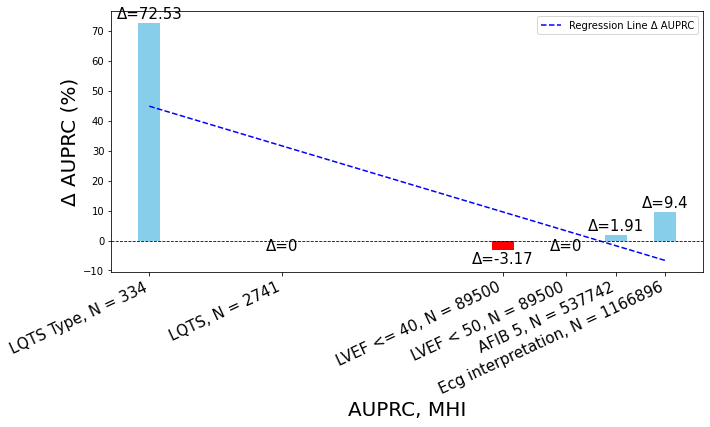

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Sample data
mhi_data = [
    ('LQTS Type', 334, 28.20, 72.53), 
    ('LQTS', 2741, 0, 0), 
    ('LVEF <= 40', 89500, 4.05, -3.17), 
    ('LVEF < 50', 89500, 0, 0), 
    ('AFIB 5', 537742, 0.81, 1.91),     
    ('Ecg interpretation', 1166896, +5.78, +9.40)
]
mimic_data = [
    #('LQTS Type', 334, 28.20, 72.53), 
    #('LQTS', 2741, ), 
    ('LVEF <=40', 89500, 2.66, 8.45), 
    ('LVEF < 50', 89500, +1.47, 3.96), 
    ('AFIB 5', 537742, 0.38, 1.50),     
    ('Ecg interpretation', 1166896, +0.16, -0.68)
]


def plot_n_delta(ds_type='MHI', metric='auroc'):
    data = mhi_data if ds_type =='MHI' else mimic_data

    categories = [f'{v}, N = {n}' for (v,n,_,_) in data]
    x = np.log([v for (_,v,_,_) in data])
    delta = [v for (_,_,v,_) in data] if metric == 'auroc' else [v for (_,_,_,v) in data]
    for i in range(len(x)-1):
        if abs(x[i]-x[i+1]) < 0.0005:
            x[i+1] += 1
    print(categories, x, delta)
    # Set up bar positions
    width = 0.35  # Width of the bars

    # Perform linear regression for Model 1
    slope, intercept, _, _, _ = linregress(x, delta)
    regression_line = slope * x + intercept

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars for both models
    bar_colors = ['red' if d < 0 else 'skyblue' for d in delta]
    bars = ax.bar(x , delta, width,  color=bar_colors) #, label=f'Δ {metric.upper()}, {ds_type}',)
    
    # Add thin vertical lines for CI
    for i in range(len(x)):
        continue
        # Model 1 CI line
        #ax.vlines(x[i] - width / 2, scores1[i] - ci_model1[i], scores1[i] + ci_model1[i], color='black', linewidth=1)
        # Model 2 CI line
        #ax.vlines(x[i] + width / 2, scores2[i] - ci_model2[i], scores2[i] + ci_model2[i], color='black', linewidth=1)

        # Calculate and add delta (difference) text
        #delta = round(scores2[i] - scores1[i], 2)
        #y_position = max(scores1[i] + ci_model1[i], scores2[i] + ci_model2[i]) + 0.5  # Position above bars
        y_position = delta
        ax.text(x[i], y_position[i], f'Δ={delta[i]}', ha='center', va='bottom', fontsize=10, color='black')

    for i, d in enumerate(delta):
        y_position = d - 0.5 if d < 0 else d + 0.5  # Position text based on delta sign
        ax.text(x[i], y_position, f'Δ={d}', ha='center', va='bottom' if d > 0 else 'top', fontsize=15, color='black')


    # Plot the regression line for Model 1
    ax.plot(x, regression_line, label=f'Regression Line Δ {metric.upper()}', color='blue', linestyle='--', linewidth=1.5,)

    # Add a horizontal line at 0 for reference
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    # Labeling and aesthetics
    ax.set_xlabel(f'{metric.upper()}, {ds_type}', fontsize=20)
    ax.set_ylabel(f'Δ {metric.upper()} (%)', fontsize=20)
    #ax.set_title(f'Comparison of {metric.upper()} gaps with number of Performance with Regression Line')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=25, ha='right', fontsize=15)
    ax.legend()

    # Adjust layout for better appearance
    plt.tight_layout()

    # Show plot
    plt.show()

plot_n_delta(ds_type='MHI', metric='auprc')


In [5]:
# Generate Ecg interpretation table
def format_scores(scores):
    Label = 'Category'
    df = scores.copy()

    if 'Label' in df.columns:
        Label = 'Label'
    for i in range(len(df)):
        if df.loc[i, Label] == 'Total':
            df.loc[i, Label] = 'ALL'
    df.index = df[Label] + '_' + df['Metrics']
    #df = df[['Mean', '95% CI']]
    return df

def bold(text, call=True):
    return '\\textbf{'+str(text)+'}' if call else '\\text{'+str(text)+'}'
def metric_block(sl_row,  ssl_row, bold_max=True):
    sl_mean, sl_ci = sl_row
    ssl_mean, ssl_ci = ssl_row
    def is_in(v, interval):
        return interval[0]<=v and v <= interval[1]
    def delta():
        diff = float(ssl_mean)-float(sl_mean)
        sl_ci_f = eval(sl_ci.replace('-', ','))
        ssl_ci_f = eval(ssl_ci.replace('-', ','))

        signif = -1 if diff < 0 else 1
        #diff = f'+{diff}' if diff > 0 else f'-{diff}'
        if is_in(sl_ci_f[0] , ssl_ci_f) or is_in(sl_ci_f[1], ssl_ci_f) or is_in(ssl_ci_f[0], sl_ci_f) or is_in(ssl_ci_f[1], sl_ci_f):
            signif = 0
        return diff, signif
    def tabular(mean, ci, best=False):
        ci = ci.replace(' - ', ', ')
        #ci = f'${ci}$'
        return '\\begin{tabular}{@{}c@{}} ' + f'{bold(mean, best)} \\\\ {bold(ci, best)} ' + '\\end{tabular}'

        
    diff, signif = delta()
    if signif == 1:
        return  f'{tabular(sl_mean, sl_ci)} & {tabular(ssl_mean,  ssl_ci, True and bold_max)} & +{float(diff):.2f} '
    elif signif == -1:
        return  f'{tabular(sl_mean, sl_ci, True and bold_max)} & {tabular(ssl_mean,  ssl_ci)} & {float(diff):.2f} '
    else:
        return  f'{tabular(sl_mean, sl_ci)} & {tabular(ssl_mean,  ssl_ci)} &  -'

def table_task_v1(caption, caption_note, label, header, categories, datasets):
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{width=\\textwidth}'
    table += '\n\t\\begin{tabular}{ll'+'c'*3*len(datasets)+'}'
    table += '\n\t\t\\toprule'
    table += header
    for _, (text, _, _) in datasets.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\bf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(datasets)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(datasets) + ' \\\\'
    table += '\n\t\t\\midrule'

    for cat, (text, metrics) in categories.items():
        table += '\n\t\t\\multirow{'+str(2*len(metrics))+'}{*}{'+text+'}'
        for mkey, metric in metrics.items():
            table += f'\n\t\t& {metric} '
            for _, (_, sl, ssl) in datasets.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl.loc[key, ['Mean', '95% CI']], ssl.loc[key, ['Mean', '95% CI']], )} " if key in sl.index else '& - & - & -'
            table += ' \\\\'
        table += '\n\t\t\\midrule'

    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    table += '\n\\end{table}'
    return table


def table_task_v2(caption, caption_note, label, header, categories, datasets, metrics, bold_best=True):
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'cc'*3*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\multirow{2}{*}{\\textbf{Dataset}} & \multirow{2}{*}{{Category}}'
    for _, text  in metrics.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\textbf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(metrics)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(metrics) + ' \\\\'
    table += '\n\t\t\\midrule'

    for dkey, (dtext, sl, ssl) in datasets.items():
        table += '\n\t\t %'+dkey
        table += '\n\t\t\\multirow{'+str(2*len(categories))+'}{*}{\\bf{'+dtext+'}}'
        for cat, text in categories.items():
            if cat == 'ALL':
                table += '\n\t\t\\cmidrule(lr){2-2} ' + ' '.join(['\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} ' for v in range(3, len(metrics)*4, 3)])
            
            table += '\n\t\t& '+text #\\multirow{2}{*}{'+text+'}'
            
            for mkey, _ in metrics.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl.loc[key, ['Mean', '95% CI']], ssl.loc[key, ['Mean', '95% CI']], bold_best)} "
            table += ' \\\\'        
        table += '\n\t\t\\midrule'

    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return table


def get_ssl_scores(results_key='last-ft-labels-77-bce', subset='test', ratio=RATIO, n_perm=N_PERM, prefix='ci_scores'):
    results_path = get_path(results_key)
    if EVAL_CI:
        return pd.read_csv(os.path.join(results_path, f"{prefix}_{subset.split('/')[-1]}_{ratio}_{n_perm}.csv"))
    else:
        return pd.read_csv(os.path.join(results_path, f"group_scores_{subset.split('/')[-1]}_{ratio}_{n_perm}.csv"))
            
def get_sl_scores(results_key='last-ft-labels-77-bce', subset='test', ratio=RATIO, n_perm=N_PERM, prefix='results'):
    results_path=''
    if subset in ['CLSA', 'MHI', 'MIMIC', 'PTB', 'UKB']:
        subset = f'{subset}_77_labels'
    results_path = '/media/data1/anolin/for_achille_ssl/for_table'
    return pd.read_csv(os.path.join(results_path, subset, f'{prefix}_{n_perm}_{ratio}_.csv'))

def get_center_scores(results_key, ratio=RATIO, n_perm=N_PERM):
    center, model, ltask = results_key.split('-')
    subset = f'{model}-{ltask}'
    results_path = f'/media/data1/achilsowa/results/fairseq/centers/{center}'
    if EVAL_CI:
        return pd.read_csv(os.path.join(results_path, f"ci_scores_{subset.split('/')[-1]}_{ratio}_{n_perm}.csv"))
    else:
        return pd.read_csv(os.path.join(results_path, f"group_scores_{subset.split('/')[-1]}_{ratio}_{n_perm}.csv"))    
    


def n_prev_df(df, label):
    total, prev = len(df), df[label].sum()
    return total, prev, f'{prev/total*100:.2f}%'

def n_prev_npy(y):
    total, prev = len(y), np.sum(y)
    return total, prev, f'{prev/total*100:.2f}%'
    
def table_ecg_interpretation(short=True, is_center=False):
    if is_center:
        uw_ssl = get_center_scores('uw-ssl-labels_77')
        uw_sl = get_center_scores('uw-sl-labels_77')
        ucsf_ssl = get_center_scores('ucsf-ssl-labels_77')
        ucsf_sl = get_center_scores('ucsf-sl-labels_77')
        datasets={
            'uw': ('UW', format_scores(uw_sl), format_scores(uw_ssl)), 
            'ucsf': ('UCSF', format_scores(ucsf_sl), format_scores(ucsf_ssl)), 
        }
        caption='Performance Metrics Across Centers (UW, UCSF)'
        caption_note='multicentric'
        
    else:
        mhi_ssl = get_ssl_scores(subset='test')
        mhi_sl = get_sl_scores(subset='MHI')
        mimic_ssl = get_ssl_scores(subset='mimic_cleaned')
        mimic_sl = get_sl_scores(subset='MIMIC')
        ptb_ssl = get_ssl_scores(subset='ptb_cleaned')
        ptb_sl = get_sl_scores(subset='PTB')
        ukb_ssl = get_ssl_scores(subset='ukbb_cleaned_high_pass_scaled')
        ukb_sl = get_sl_scores(subset='UKB')
        clsa_ssl = get_ssl_scores(subset='clsa_cleaned')
        clsa_sl = get_sl_scores(subset='CLSA')
        datasets={
            'mhi': ('MHI', format_scores(mhi_sl), format_scores(mhi_ssl)), 
            'mimic': ('MIMIC', format_scores(mimic_sl), format_scores(mimic_ssl)), 
            'ptb': ('PTB', format_scores(ptb_sl), format_scores(ptb_ssl)), 
            'ukbb': ('UKB', format_scores(ukb_sl), format_scores(ukb_ssl)), 
            'clsa': ('CLSA', format_scores(clsa_sl), format_scores(clsa_ssl))
        },
        caption='Performance Metrics Across Datasets (MHI, MIMIC, PTB, UKB, CLSA)'
        caption_note='MHI refers to the preprocessed MHI-test dataset, MIMIC refers to preprocessed MIMIC-IV-test dataset, PTB refers to the preprocessed PTB-XL dataset, UKB refers to the preprocessed  UK Biobank dataset and CLSA refers to the preprocessed CLSA dataset.'
        

    if short:
        header = '\n\t\t\\multirow{2}{*}{Category} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
        metrics = {'micro_auroc': 'AUROC',  'micro_auprc': 'AUPRC'}
        label='tab:ecg_interpretation_short'
        
    else:
        header = '\n\t\t\\multirow{2}{*}{Category} & \\multirow{2}{*}{\\shortstack{Metrics}}',
        metrics = {
            'micro_auroc': 'micro auroc', 'macro_auroc': 'macro auroc', 
            'micro_f1score': 'micro f1score', 'macro_f1score': 'macro f1score', 
            'micro_auprc': 'micro auprc', 'macro_auprc': 'macro auprc'}
        label='tab:ecg_interpretation_long'
    
    #metrics = {'micro_auroc': 'micro auroc'}
    table = table_task_v2(
        caption=caption,
        caption_note=caption_note,
        label=label,
        header=header,
        categories={
            'RHYTHM': 'RHYTHM', 'CONDUCTION': 'CONDUCTION', 'CHAMBER ENLARGEMENT': 'CHAMBER ENLARGEMENT',
            'PERICARDITIS': 'PERICARDITIS','INFARCT, ISCHEMIA': 'INFARCT, ISCHEMIA', 'OTHER': 'OTHER', 'ALL': '\\textbf{TOTAL}' },
        datasets=datasets,
        metrics=metrics   
    )
    print(table.expandtabs(2))
    return table

    
def table_privacy():
    prefix = 'privacy'
    mhi_ssl = get_ssl_scores(subset='test', prefix=prefix)
    mhi_sl = get_sl_scores(subset='MHI', prefix=prefix)
    mimic_ssl = get_ssl_scores(subset='mimic_cleaned', prefix=prefix)
    mimic_sl = get_sl_scores(subset='MIMIC', prefix=prefix)
    ptb_ssl = get_ssl_scores(subset='ptb_cleaned', prefix=prefix)
    ptb_sl = get_sl_scores(subset='PTB', prefix=prefix)
    ukb_ssl = get_ssl_scores(subset='ukbb_cleaned_high_pass_scaled', prefix=prefix)
    ukb_sl = get_sl_scores(subset='UKB', prefix=prefix)
    clsa_ssl = get_ssl_scores(subset='clsa_cleaned', prefix=prefix)
    clsa_sl = get_sl_scores(subset='CLSA', prefix=prefix)

    header = '\n\t\t\\multirow{2}{*}{Category} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC',  'auprc': 'AUPRC'}
    label='tab:privacy'
        
    table = table_task_v2(
        caption='Membership Inference Attack Evaluation Metrics for MIMIC, UKB, MHI, and PTB Datasets',
        caption_note=None,
        label=label,
        header=header,
        categories={
            'privacy': 'Privacy'},
        datasets={
            'mhi': ('MHI', format_scores(mhi_sl), format_scores(mhi_ssl)), 
            'mimic': ('MIMIC', format_scores(mimic_sl), format_scores(mimic_ssl)), 
            'ptb': ('PTB', format_scores(ptb_sl), format_scores(ptb_ssl)), 
            'ukbb': ('UKB', format_scores(ukb_sl), format_scores(ukb_ssl)), 
            'clsa': ('CLSA', format_scores(clsa_sl), format_scores(clsa_ssl))
        },
        metrics=metrics,
        bold_best=False
    )
    print(table.expandtabs(2))
    return table


def table_finetune():
    ssl_keys = ['fevg-v2-40-bce', 'fevg-v2-50-bce', 'fevg-reg-mse', 'afib-v2-5-bf', 'lqts-bf', 'lqts-type-bf']
    sl_keys = ['LVEF_40', 'LVEF_50', 'LVEF_REG', 'AFIB_5', 'LQTS', 'LQTS_TYPE']

    mhi_ssl = pd.concat(
        [get_ssl_scores(results_key=f'last-ft-{key}', subset='test') for key in ssl_keys], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    mhi_sl = pd.concat(
        [get_sl_scores(subset=f'MHI_{key}') for key in sl_keys], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    mimic_ssl = pd.concat(
        [get_ssl_scores(results_key=f'last-ft-{key}', subset='mimic_cleaned') for key in ssl_keys[:-2]], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    mimic_sl = pd.concat(
        [get_sl_scores(subset=f'MIMIC_{key}') for key in sl_keys[:-2]], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    
    def ftitle(title, n1, prev1, n2, prev2):
        title ='\\shortstack[l]{\\bf{' + title + '}' + '\\\\ \\scriptsize N_{mhi}= '+str(n1)
        if prev1 is not None: 
            title += f' ({prev1/n1*100:.1f}\\%)'
        if n2 is not None:
            title += ' \\\\ \\scriptsize N_{mimic} = '+str(n2)
        if prev2 is not None: 
            title += f' ({prev2/n2*100:.1f}\\%)'
        title += '}'
        return title
    
    cls_metrics={'f1score': 'F1 Score', 'auroc': 'AUROC', 'auprc': 'AUPRC'}
    reg_metrics = {'mse': 'MSE', 'r2': 'R$^{2}$', 'pearson_correlation': 'Pearson Correlation'}
    categories={
        'LVEF_EQUAL_OR_UNDER_40_tte_lvef': (ftitle('LVEF $\leq$ 40', 25252, 2093.0, 5524, 1076,), cls_metrics), 
        'LVEF_UNDER_50_tte_lvef': (ftitle('LVEF $<$ 50', 25252, 3522.0, 5524, 1772), cls_metrics), 
        'Visually Estimated EF_tte_lvef': (ftitle('LVEF Regression', 16564, None, 5524, None), reg_metrics),
        'label_5y': (ftitle('AFIB 5 years', 132050, 15533, 437323, 65301.0),  cls_metrics), 
        'LQTS': (ftitle('LQTS', 943, 127, None, None), cls_metrics), 
        'LQTS_TYPE_1': (ftitle('LQTS Type', 127, 99, None, None), cls_metrics) 
    }
        
    table = table_task_v1(
        caption='Performance of Fine-tuned Tasks Across Datasets (MHI, MIMIC)',
        caption_note= 'MHI refers to the preprocessed MHI-test set, while MIMIC refers to the preprocessed MIMIC-IV-test set',
        label='tab:finetune_task_short',
        header='\n\t\t\\multirow{2}{*}{\\shortstack[l]{\\bf{Task} \\\\ \\scriptsize N = Sample size (Prevalance \%)}} & \multirow{2}{*}{{Metrics}}',
        #header='\n\t\t\\multirow{2}{*}{Category} & \multirow{2}{*}{\shortstack{metrics \\\\ (micro)}}',
        categories=categories,
        datasets={
            'mhi': ('MHI', format_scores(mhi_sl), format_scores(mhi_ssl), ), 
            'mimic': ('MIMIC', format_scores(mimic_sl), format_scores(mimic_ssl)), 
        },   
    )
    
    print(table.expandtabs(2))
    return table

#table = table_ecg_interpretation(is_center=True)
#table = table_finetune()
#table = table_privacy()

NameError: name 'RATIO' is not defined

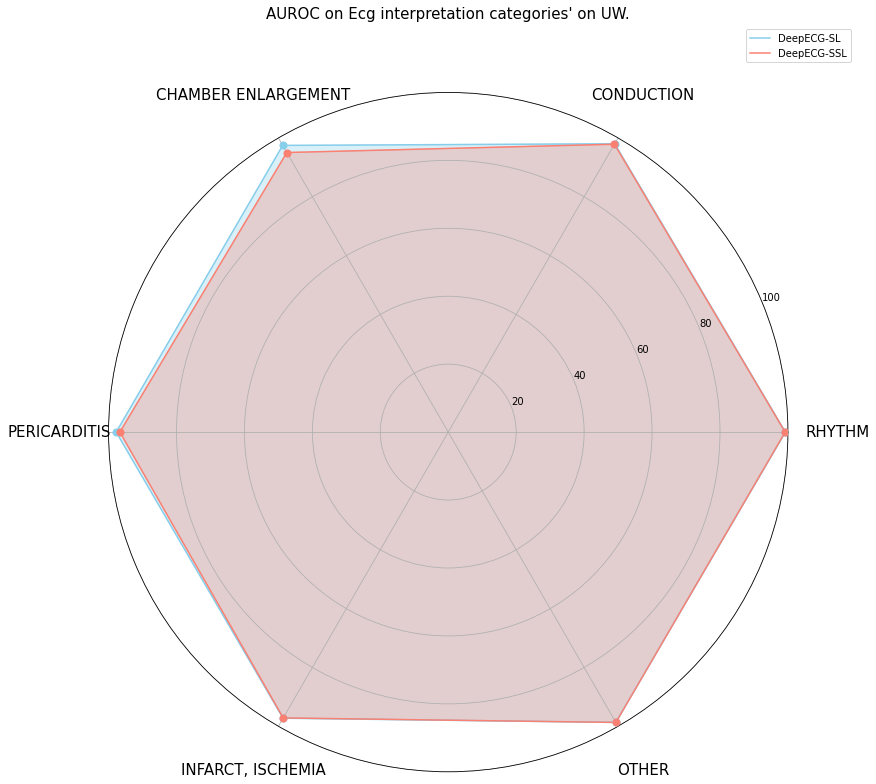

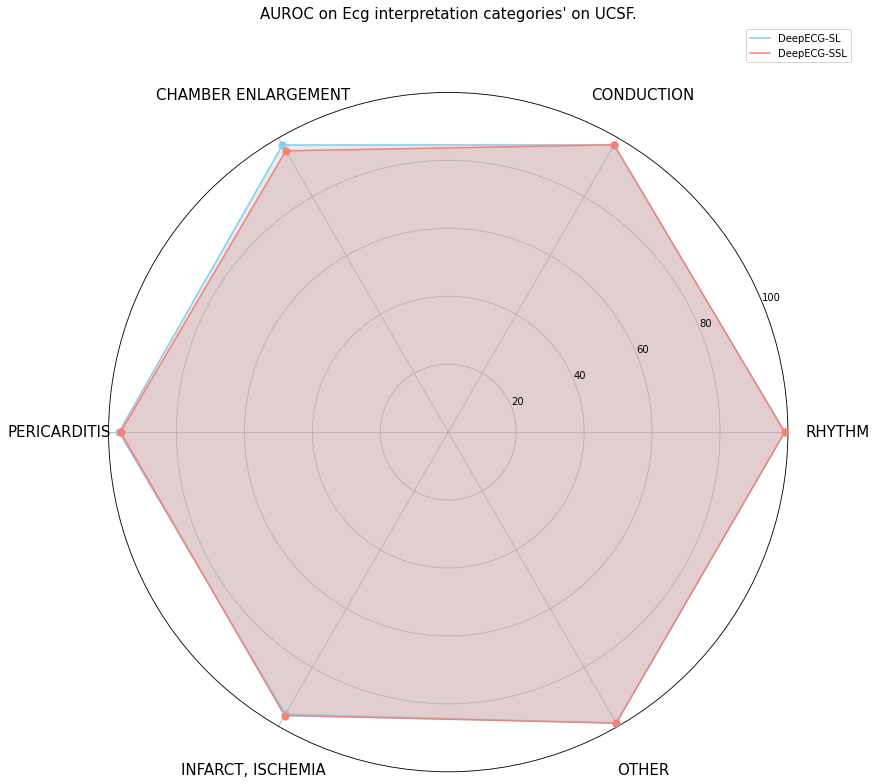

FileNotFoundError: [Errno 2] No such file or directory: '/media/data1/achilsowa/results/fairseq/centers/cshs/ci_scores_sl-lvef_40_0.7_1000.csv'

In [9]:
def plot_spider(models, categories, title):

    # Sample data
    #categories = [cat for _, cat in categories.items()]
    

    def plot_graph(): 
        # Number of variables we're plotting
        num_vars = len(categories)

        # Compute angle of each category for the radar plot
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

        # The radar chart needs the data to be a closed loop, so append the start to the end.
        for model in models:          
            scores = model['df'].loc[list(categories.keys()), 'Mean'].tolist()
            scores += scores[:1]
            model['scores'] = scores
        angles += angles[:1]

        # Initialize the radar chart
        fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

        # Plot each model’s data on the radar chart
        for model in models:
            ax.plot(angles, model['scores'], linewidth=1.5, linestyle='solid', label=model['title'], color=model['color'])
            ax.fill(angles, model['scores'], color=model['color'], alpha=0.3)
            ax.scatter(angles[:-1], model['scores'][:-1], color=model['color'], s=50, zorder=5)  # Exclude the repeated first point

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories.values(), ha='center')
        angles = np.array(angles)
        angles[np.cos(angles) < 0] = angles[np.cos(angles) < 0] + np.pi
        angles = np.rad2deg(angles) 
        labels = []
        for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
            x,y = label.get_position()
            #print(x, y, angle, label.get_text())
            lab = ax.text(x,y-.105, label.get_text(), transform=label.get_transform(),
                            ha=label.get_ha(), va=label.get_va(), fontsize=15)
            #lab.set_rotation(angle) 
            labels.append(lab)
        #ax.set_xticks(angles[:-1])
        ax.set_xticklabels([])
        #ax.set_xticklabels(categories.values(), ha='center')


        # Set the range for the radial axis (AUC percentage from 0 to 100)
        ax.set_ylim(0, 100)

        # Remove default x-ticks as we use custom labels
        #ax.set_xticks([])
        
        # Add title and legend
        plt.title(title, size=15, color='black', y=1.1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), )
        plt.tight_layout()
        plt.show()

    plot_graph()

#def get_labels_77_df(subset)

def get_categories(tasks, metric='auroc'):
    categories = {}
    for task in tasks:
        if task == 'labels_77':
            categories[f'RHYTHM_micro_{metric}'] = 'RHYTHM'
            categories[f'CONDUCTION_micro_{metric}'] = 'CONDUCTION'
            categories[f'CHAMBER ENLARGEMENT_micro_{metric}'] = 'CHAMBER ENLARGEMENT'
            categories[f'PERICARDITIS_micro_{metric}'] = 'PERICARDITIS'
            categories[f'INFARCT, ISCHEMIA_micro_{metric}'] = 'INFARCT, ISCHEMIA'
            categories[f'OTHER_micro_{metric}'] = 'OTHER'
            categories[f'ALL_micro_{metric}'] = 'TOTAL'
        elif task == 'lvef_40':
            categories[f'LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}'] = 'LVEF ≤ 40'
        elif task == 'lvef_50':
            categories[f'LVEF_UNDER_50_tte_lvef_{metric}'] ='LVEF < 50'
        elif task == 'afib_5':
            categories[f'label_5y_{metric}'] ='iAF5' 
        elif task == 'lqts':
            categories[f'LQTS_{metric}'] = 'LQTS'
        elif task == 'lqts_type':
            categories[f'LQTS_TYPE_1_{metric}'] = 'LQTS Type'
    return categories


def get_sl_df(subset, tasks):
    #subset_map = {'mhi': 'MHI', 'clsa': 'CLSA', 'ukb': 'UKB', 'mimic': 'MIMIC', 'ptb': 'PTB'}
    #tasks_map = {'labels_77': 'LABELS_77', 'lvef_40': 'LVEF_40', 'lvef_50': 'LVEF_50', 'afib_5': 'AFIB_5', 'lqts': 'LQTS', 'lqts_type': 'LQTS_TYPE'}
    #subset = subset_map[subset]
    dfs = [get_sl_scores(subset=f'{subset.upper()}_{key.upper()}') for key in tasks]
    df = pd.concat([format_scores(ldf.reset_index(drop=True).rename(columns={'Label': 'Category'})) for ldf in dfs], axis=0)
    return df
def get_ssl_df(subset, tasks):
    subset_map = {'mhi': 'test', 'clsa': 'clsa_cleaned', 'ukb': 'ukbb_cleaned_high_pass_scaled', 'mimic': 'mimic_cleaned', 'ptb': 'ptb_cleaned'}
    tasks_map = {'labels_77': 'labels-77-bce', 'lvef_40': 'fevg-v2-40-bce', 'lvef_50': 'fevg-v2-50-bce', 'afib_5': 'afib-v2-5-bf', 'lqts': 'lqts-bf', 'lqts_type': 'lqts-type-bf'}
    subset = subset_map[subset]
    dfs = [get_ssl_scores(results_key=f'last-ft-{tasks_map[key]}', subset=subset) for key in tasks]
    df = pd.concat([format_scores(ldf.reset_index(drop=True).rename(columns={'Label': 'Category'})) for ldf in dfs], axis=0)
    return df
def get_center_df(subset, tasks):
    dfs = [get_center_scores(f'{subset}-{key}') for key in tasks]
    df = pd.concat([format_scores(ldf.reset_index(drop=True).rename(columns={'Label': 'Category'})) for ldf in dfs], axis=0)
    return df

def get_sl_ssl_df(subset):
    if subset == 'mhi':
        tasks = ['labels_77', 'lvef_50', 'lvef_40', 'afib_5', 'lqts', 'lqts_type']
        sl = get_sl_df(subset, tasks)
        ssl = get_ssl_df(subset, tasks)
    elif subset == 'mimic':
        tasks = ['labels_77', 'lvef_50', 'lvef_40', 'afib_5']
        sl = get_sl_df(subset, tasks)
        ssl = get_ssl_df(subset, tasks)
    elif subset in ['ptb', 'clsa', 'ukb']:
        tasks = ['labels_77']
        sl = get_sl_df(subset, tasks)
        ssl = get_ssl_df(subset, tasks)
    elif subset in ['external_public']:
        tasks = ['labels_77']
        sl = get_sl_df(subset, tasks)
        ssl = get_ssl_df(subset, tasks)
    elif subset in ['uw']:
        sl =  get_center_df(f'{subset}-sl', ['labels_77', 'lvef_40', 'lvef_50'])
        ssl =  get_center_df(f'{subset}-ssl', ['labels_77', 'lvef_40', 'lvef_50'])
    elif subset in ['ucsf']:
        sl =  get_center_df(f'{subset}-sl', ['labels_77', 'lvef_40', 'lvef_50', 'afib_5'])
        ssl =  get_center_df(f'{subset}-ssl', ['labels_77', 'lvef_40', 'lvef_50', 'afib_5',])
    elif subset in ['cshs']:
        sl =  get_center_df(f'{subset}-sl', ['labels_77', 'lvef_40', 'lvef_50', 'afib_5'])
        ssl =  get_center_df(f'{subset}-ssl', ['labels_77', 'lvef_40', 'lvef_50', 'afib_5',])
    elif subset in ['hms']:
        sl =  get_center_df(f'{subset}-sl', ['labels_77'])
        ssl =  get_center_df(f'{subset}-ssl', ['labels_77'])
    elif subset in ['nyp']:
        sl =  get_center_df(f'{subset}-sl', ['labels_77', 'lvef_40', 'lvef_50'])
        ssl =  get_center_df(f'{subset}-ssl', ['labels_77', 'lvef_40', 'lvef_50'])
    elif subset in ['external_private']:
        sl =  get_center_df(f'{subset}-sl', ['labels_77', 'lvef_40', 'lvef_50', 'afib_5'])
        ssl =  get_center_df(f'{subset}-ssl', ['labels_77', 'lvef_40', 'lvef_50', 'afib_5',])
    else:
        assert False, f'Wrong subset {subset}'

    return sl, ssl

def plot_dataset_spider(subset, title, tasks, metric='auroc'):
    sl, ssl = get_sl_ssl_df(subset)
    #ssl = get_ssl_df(subset, tasks)
    
    categories = get_categories(tasks, metric)
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
    ]
    plot_spider(models, categories, title)


def plot_all_spider(title, metric='auroc'):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': []}
    jabbour = {
        'key': ['mhi_label_5y_auroc', 'mhi_label_5y_auprc', 'mimic_label_5y_auroc', 'mimic_label_5y_auprc'], 
        'Mean': [75.71, 33.06, 70.60, 29.97], '95% CI': [0, 0, 0, 0]
    }
    jiang = {
        'key': ['mhi_LQTS_auroc', 'mhi_LQTS_auprc', 'mhi_LQTS_TYPE_1_auroc', 'mhi_LQTS_TYPE_auprc'], 
        'Mean': [70.17, 23.00, 69.64, 42.2], '95% CI': [0, 0, 0, 0]
    }
    hou = {
        'key': ['mhi_LVEF_UNDER_50_tte_lvef_auroc', 'mhi_LVEF_UNDER_50_tte_lvef_auprc'],
        'Mean': [84.80, 0], '95% CI': [0, 0]
    }
    def update_dict(subset, idx):
        fdf_sl, fdf_ssl = get_sl_ssl_df(subset)
        idx = f'{idx}_{metric}'
        sl['key'] += [f'{subset}_{idx}']
        ssl['key'] += [f'{subset}_{idx}']
        sl['Mean'] += [fdf_sl.loc[idx, 'Mean']]
        ssl['Mean'] += [fdf_ssl.loc[idx, 'Mean']]
        sl['95% CI'] += [fdf_sl.loc[idx, '95% CI']]
        ssl['95% CI'] += [fdf_ssl.loc[idx, '95% CI']]

    def to_df(df_dict):
        for key in categories.keys():
            if not key in df_dict['key']:
                df_dict['key'] += [key]
                df_dict['Mean'] += [0]
                df_dict['95% CI'] += [0]
        df = pd.DataFrame(df_dict)
        df.index = df['key']
        return df

    for subset in ['mhi', 'mimic', 'ptb', 'clsa', 'ukb', 'uw', 'ucsf']:
        update_dict(subset, 'ALL_micro')
    for subset in ['mhi', 'mimic']:
        update_dict(subset, 'label_5y')
    for subset in ['mhi', 'mimic', 'uw', 'ucsf']:
        update_dict(subset, 'LVEF_EQUAL_OR_UNDER_40_tte_lvef')
        update_dict(subset, 'LVEF_UNDER_50_tte_lvef')
    for subset in ['mhi']:
        update_dict(subset, 'LQTS')
        update_dict(subset, 'LQTS_TYPE_1')

    categories = {
        f'mhi_ALL_micro_{metric}': 'TOTAL (MHI)', 
        f'mimic_ALL_micro_{metric}': 'TOTAL (MIMIC-IV)', 
        f'ptb_ALL_micro_{metric}': 'TOTAL (PTB)', 
        f'ukb_ALL_micro_{metric}': 'TOTAL (UKB)', 
        f'clsa_ALL_micro_{metric}': 'TOTAL (CLSA)', 
        f'uw_ALL_micro_{metric}': 'TOTAL (UW)', 
        f'ucsf_ALL_micro_{metric}': 'TOTAL (UCSF)', 
        f'mhi_LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}': 'LVEF ≤ 40 (MHI)',
        f'mimic_LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}': 'LVEF ≤ 40 (MIMIC-IV)',
        f'mhi_LVEF_UNDER_50_tte_lvef_{metric}': 'LVEF < 50 (MHI)',
        f'mimic_LVEF_UNDER_50_tte_lvef_{metric}': 'LVEF < 50 (MIMIC-IV)',
        f'mhi_label_5y_{metric}': 'iAF5 (MHI)',
        f'mimic_label_5y_{metric}': 'iAF5 (MIMIC-IV)',
        f'mhi_LQTS_{metric}': 'LQTS (MHI)',
        f'mhi_LQTS_TYPE_1_{metric}': 'LQTS Type (MHI)'
    }

    sl = to_df(sl)
    ssl = to_df(ssl)
    jabbour = to_df(jabbour)
    hou = to_df(hou)
    jiang = to_df(jiang)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
        {'title': 'Jabbour et al. (2024)', 'df': jabbour, 'color': 'g'},
        {'title': 'Hou et al. (2024)', 'df': hou, 'color': 'm'},
        {'title': 'Jiang et al. (2024)', 'df': jiang, 'color': 'y'}
    ]
    plot_spider(models, categories, f'{title} {metric.upper()}')


def plot_ecg_interpretation_main(title, metric='auroc'):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': []}
    def update_dict(subset, idx):
        fdf_sl, fdf_ssl = get_sl_ssl_df(subset)
        idx = f'{idx}_{metric}'
        sl['key'] += [f'{subset}_{idx}']
        ssl['key'] += [f'{subset}_{idx}']
        sl['Mean'] += [fdf_sl.loc[idx, 'Mean']]
        ssl['Mean'] += [fdf_ssl.loc[idx, 'Mean']]
        sl['95% CI'] += [fdf_sl.loc[idx, '95% CI']]
        ssl['95% CI'] += [fdf_ssl.loc[idx, '95% CI']]

    def to_df(df_dict):
        for key in categories.keys():
            if not key in df_dict['key']:
                df_dict['key'] += [key]
                df_dict['Mean'] += [0]
                df_dict['95% CI'] += [0]
        df = pd.DataFrame(df_dict)
        df.index = df['key']
        return df

    for subset in ['mhi', 'mimic', 'ptb', 'clsa', 'ukb', 'uw', 'ucsf']:
        update_dict(subset, 'ALL_micro')
    
    categories = {
        f'mhi_ALL_micro_{metric}': 'MHI', 
        f'mimic_ALL_micro_{metric}': 'MIMIC-IV', 
        f'ptb_ALL_micro_{metric}': 'PTB', 
        f'ukb_ALL_micro_{metric}': 'UKB', 
        f'clsa_ALL_micro_{metric}': 'CLSA', 
        f'uw_ALL_micro_{metric}': 'UW', 
        f'ucsf_ALL_micro_{metric}': 'UCSF', 
    }

    sl = to_df(sl)
    ssl = to_df(ssl)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
    ]
    plot_spider(models, categories, f'{title} {metric.upper()}')


def plot_ecg_interpretation_ds_group(title, group='internal', metric='auroc'):
    #assert group in ['mhi', 'internal', 'external_public', 'external_private'], f'unkown group {group}'
    
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': []}
    def update_dict(subset, idx):
        fdf_sl, fdf_ssl = get_sl_ssl_df(subset)
        idx = f'{idx}_{metric}'
        sl['key'] += [f'{subset}_{idx}']
        ssl['key'] += [f'{subset}_{idx}']
        sl['Mean'] += [fdf_sl.loc[idx, 'Mean']]
        ssl['Mean'] += [fdf_ssl.loc[idx, 'Mean']]
        sl['95% CI'] += [fdf_sl.loc[idx, '95% CI']]
        ssl['95% CI'] += [fdf_ssl.loc[idx, '95% CI']]

    def to_df(df_dict):
        for key in categories.keys():
            if not key in df_dict['key']:
                df_dict['key'] += [key]
                df_dict['Mean'] += [0]
                df_dict['95% CI'] += [0]
        df = pd.DataFrame(df_dict)
        df.index = df['key']
        return df

    for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
        update_dict(group, f'{cat}_micro')
    categories = {
        f'{group}_RHYTHM_micro_{metric}': 'RHYTHM', 
        f'{group}_CONDUCTION_micro_{metric}': 'CONDUCTION', 
        f'{group}_CHAMBER ENLARGEMENT_micro_{metric}': 'CHAMBER ENLARGEMENT', 
        f'{group}_PERICARDITIS_micro_{metric}': 'PERICARDITIS', 
        f'{group}_INFARCT, ISCHEMIA_micro_{metric}': 'INFARCT, ISCHEMIA', 
        f'{group}_OTHER_micro_{metric}': 'OTHER', 
        #f'{group}_ALL_micro_{metric}': 'TOTAL', 
    }

    sl = to_df(sl)
    ssl = to_df(ssl)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
    ]
    plot_spider(models, categories, title)




#plot_dataset_spider(title='Model performance on MHI. AUROC', subset='mhi', tasks=['labels_77', 'lvef_50', 'lvef_40', 'afib_5', 'lqts', 'lqts_type'])
#plot_dataset_spider(title='Model performance on MIMIC-IV. AUROC', subset='mimic', tasks=['labels_77', 'lvef_50', 'lvef_40', 'afib_5', ])
#plot_dataset_spider(title='Model performance on EHC datasets. AUROC', subset='ucsf', tasks=['labels_77', 'lvef_50', 'lvef_40', 'afib_5', ])
#plot_ecg_interpretation_main('AUROC on Ecg interpretation accross datasets.', metric='auroc')
#plot_ecg_interpretation_ds_group('AUROC on Ecg interpretation categories\' accross EHC datasets.', group='external_private', metric='auroc')
#plot_ecg_interpretation_ds_group('AUROC on Ecg interpretation categories\' accross EPC datasets.', group='external_public', metric='auroc')
#plot_ecg_interpretation_ds_group('AUROC on Ecg interpretation categories\' accross internal datasets (MHI).', group='mhi', metric='auroc')
for subset, title in [('mhi', 'MHI'), ('mimic', 'MIMIC-IV'), ('ptb', 'PTB'), ('ukb', 'UKB'), ('clsa',  'CLSA')]:
    continue
    plot_ecg_interpretation_ds_group(f'AUROC on Ecg interpretation categories\' on {title}.', group=subset, metric='auroc')
for subset, title in [('uw', 'UW'), ('ucsf', 'UCSF'), ('cshs', 'CSHS'), ('hms', 'HMS'), ('clsa',  'CLSA')]:
    plot_ecg_interpretation_ds_group(f'AUROC on Ecg interpretation categories\' on {title}.', group=subset, metric='auroc')

In [29]:
format_scores(get_center_scores('external_private-sl-labels_77'))

,Unnamed: 0,Category,Metrics,Mean,95% CI
RHYTHM_acc,0,RHYTHM,acc,13.43,[13.42 - 13.44]
RHYTHM_micro_auroc,1,RHYTHM,micro_auroc,99.24,[99.23 - 99.24]
RHYTHM_macro_auroc,2,RHYTHM,macro_auroc,95.88,[95.67 - 96.14]
RHYTHM_micro_f1score,3,RHYTHM,micro_f1score,25.06,[25.04 - 25.07]
RHYTHM_macro_f1score,4,RHYTHM,macro_f1score,17.90,[17.89 - 17.92]
RHYTHM_micro_auprc,5,RHYTHM,micro_auprc,96.45,[96.42 - 96.48]
RHYTHM_macro_auprc,6,RHYTHM,macro_auprc,63.87,[63.55 - 64.19]
CONDUCTION_acc,7,CONDUCTION,acc,2.53,[2.52 - 2.54]
CONDUCTION_micro_auroc,8,CONDUCTION,micro_auroc,96.69,[96.66 - 96.71]
CONDUCTION_macro_auroc,9,CONDUCTION,macro_auroc,89.63,[89.08 - 90.18]


In [30]:
import numpy as np
import pandas as pd
n_afib_mhi=132050, 
n_afib_mimic=437323, 
n_lqts = 943, 
n_lqts_type = 127, 
n_fevg_50 = 25252, 
n_fevg_40 = 25252
def n_prev_df(df, label):
    total, prev = len(df), df[label].sum()
    return total, prev, f'{prev/total*100:.2f}%'

def n_prev_npy(y):
    total, prev = len(y), np.sum(y)
    return total, prev, f'{prev/total*100:.2f}%'

#n_prev_df(pd.read_parquet('/media/data1/achilsowa/datasets/afib/Afib_filtered_lite_test.parquet'), 'label_5y')
#n_prev_npy(np.load('/media/data1/datasets/MHI/mimic_afib_y.npy'))
#n_prev_df(pd.read_csv('/media/data1/ravram/DeepECG_Datasets/mhi-lqts-type-test-lite.csv'), 'LQTS_TYPE_1')
#n_prev_df(pd.read_csv('/media/data1/ravram/DeepECG_Datasets/test_filtered_echo_v2.csv'), 'LVEF_EQUAL_OR_UNDER_40_tte_lvef')
#n_prev_df(pd.read_csv('/media/data1/ravram/DeepECG_Datasets/test_filtered_lite_LVEF_Continuous.csv'), 'Visually Estimated EF_tte_lvef')
n_prev_npy(np.load('/media/data1/anolin/lvef_mimic_ecg_cleaned_LVEF_Y_final.npy'))
n_prev_npy(np.load('/media/data1/anolin/lvef_mimic_ecg_cleaned_LVEF_40_Y_final.npy'))

(5524, 1076, '19.48%')

(16564,) (16564,)


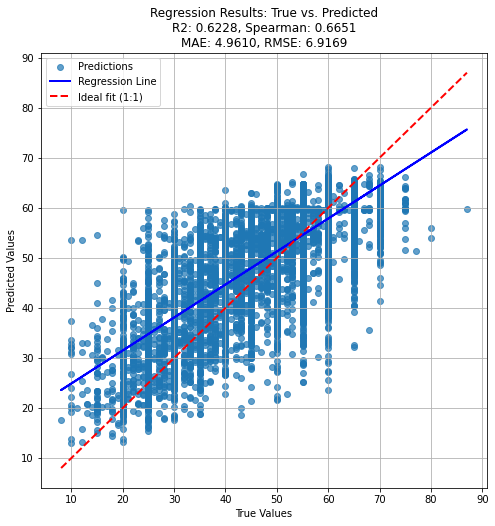

In [27]:
from scipy.stats import spearmanr, linregress
from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_regression_results_with_metrics(model=None, test_dataloader=None, y_true=None, y_pred=None):
    device = 'cuda:0'

    if model is not None: 
        model.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred = []
    
        with torch.no_grad():  # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Ensure the outputs are in the correct shape
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())

        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

    # Calculate R2 score
    r2_metric = R2Score().to(device)
    r2_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    r2_value = r2_metric.compute().item()

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_true, y_pred)

    # Calculate additional metrics: MAE and RMSE
    mae_metric = MeanAbsoluteError().to(device)
    mse_metric = MeanSquaredError(squared=False).to(device)  # RMSE

    mae_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    mse_metric.update(torch.tensor(y_pred), torch.tensor(y_true))

    mae_value = mae_metric.compute().item()
    rmse_value = mse_metric.compute().item()

    # Linear regression for the regression line
    slope, intercept, _, _, _ = linregress(y_true, y_pred)
    regression_line = slope * y_true + intercept

    # Plotting the true values vs predicted values
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, label="Predictions", alpha=0.7)
    plt.plot(y_true, regression_line, 'b-', lw=2, label="Regression Line")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label="Ideal fit (1:1)")

    # Add labels, title, and metrics
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(
        f"Regression Results: True vs. Predicted\n"
        f"R2: {r2_value:.4f}, Spearman: {spearman_corr:.4f}\n"
        f"MAE: {mae_value:.4f}, RMSE: {rmse_value:.4f}"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_lvef_reg(results_key, root_dir='/volume/deepecg/fairseq-signals/outputs', subset='test'):
    results_path = get_path(results_key, root_dir)
    header_pkl=f"{results_path}/outputs_{subset}_header.pkl"
    header_npy=f"{results_path}/outputs_{subset}.npy"
    header = np.load(header_pkl, allow_pickle=True)
    y_pred = np.memmap(header_npy, 
        mode='r',
        shape=header['shape'],
        dtype=header['dtype']
    )
    df = pd.read_csv('/media/data1/ravram/DeepECG_Datasets/test_filtered_lite_LVEF_Continuous.csv')
    y_true = df['Visually Estimated EF_tte_lvef'].to_numpy()
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    print(y_pred.shape, y_true.shape)
    
    plot_regression_results_with_metrics(y_pred=y_pred, y_true=y_true)

    
plot_lvef_reg('last-ft-fevg-reg-mse')
        

In [10]:
y = np.load("/media/data1/anolin/for_achille_ssl/NEW_DS/UKB_cleaned_high_pass_scaled/Y_UKB.npy")
y.shape

(54959, 77)

In [ ]:
folders_str = '10:1000:100000'

folder_name_len, skip, total = [int(x) for x in folders_str.split(':')]
#final_list = ['A-Z'] + [str(i*skip).zfill(folder_name_len) for i in range(total)]
final_list = [str(i*skip).zfill(folder_name_len) for i in range(total)]

len(final_list), final_list[:10], final_list[-10:]

#### Fairness and Privacy

In [5]:
import torch
import numpy as np
from tqdm import tqdm

#IMPORTANT ONE
def equalized_odds_with_average_pairwise_disparities(predictions, true_labels, protected_attributes, average='macro', 
                                                     num_iterations=1000, sample_fraction=0.7):
    """
    Calculate Equalized Odds using the average pairwise TPR/FPR disparities across groups with micro or macro averaging.

    Args:
        predictions (np.ndarray): Model predictions (N, num_labels) as binary values.
        true_labels (np.ndarray): True labels (N, num_labels) as binary values.
        protected_attributes (np.ndarray): Group membership (N,).
        average (str): 'micro' or 'macro' for averaging disparities.
        num_iterations (int): Number of iterations for permutation sampling.
        sample_fraction (float): Fraction of the data to sample in each iteration.

    Returns:
        dict: Mean and 95% CI for average pairwise TPR and FPR differences across groups.
    """
    # Convert inputs to PyTorch tensors
    predictions = torch.tensor(predictions, dtype=torch.float32)
    true_labels = torch.tensor(true_labels, dtype=torch.float32)
    protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)

    # Helper function to calculate TPR and FPR for a group
    def calculate_rates(group_preds, group_labels):
        true_positive = (group_preds * group_labels).sum(dim=0)
        false_positive = (group_preds * (1 - group_labels)).sum(dim=0)
        total_positive = group_labels.sum(dim=0)
        total_negative = (1 - group_labels).sum(dim=0)

        # Avoid division by zero by setting TPR or FPR to zero if the denominator is zero
        tpr = torch.where(total_positive > 0, true_positive / total_positive, torch.zeros_like(total_positive))
        fpr = torch.where(total_negative > 0, false_positive / total_negative, torch.zeros_like(total_negative))
        return tpr, fpr

    # Initialize storage for pairwise disparities
    tpr_diffs = []
    fpr_diffs = []

    # Iterate through permutations
    for _ in tqdm(range(num_iterations), desc="Calculating Equalized Odds"):
        # Randomly sample a fraction of the dataset
        sample_size = int(sample_fraction * len(predictions))
        indices = torch.randperm(len(predictions))[:sample_size]
        sampled_predictions = predictions[indices]
        sampled_true_labels = true_labels[indices]
        sampled_protected_attributes = protected_attributes[indices]

        # Calculate TPR and FPR for each group
        unique_groups = torch.unique(sampled_protected_attributes)
        group_rates = {}

        for group in unique_groups:
            group_mask = sampled_protected_attributes == group
            group_preds = sampled_predictions[group_mask]
            group_labels = sampled_true_labels[group_mask]
            group_rates[group.item()] = calculate_rates(group_preds, group_labels)

        # Extract TPRs and FPRs
        tprs = torch.stack([rate[0] for rate in group_rates.values()])  # TPR for each group (num_labels,)
        fprs = torch.stack([rate[1] for rate in group_rates.values()])  # FPR for each group (num_labels,)

        # Compute disparities based on averaging method
        if average == 'micro':
            # Micro: Compute disparity for each label and average across labels
            avg_tpr_diff = torch.mean(torch.abs(tprs.unsqueeze(1) - tprs.unsqueeze(0))).item()
            avg_fpr_diff = torch.mean(torch.abs(fprs.unsqueeze(1) - fprs.unsqueeze(0))).item()
        elif average == 'macro':
            # Macro: Compute disparity across groups for each label and average
            avg_tpr_diff = torch.mean(torch.mean(torch.abs(tprs.unsqueeze(1) - tprs.unsqueeze(0)), dim=(0, 1))).item()
            avg_fpr_diff = torch.mean(torch.mean(torch.abs(fprs.unsqueeze(1) - fprs.unsqueeze(0)), dim=(0, 1))).item()
        else:
            raise ValueError("average must be 'micro' or 'macro'")

        tpr_diffs.append(avg_tpr_diff)
        fpr_diffs.append(avg_fpr_diff)

    # Calculate mean and 95% confidence intervals for pairwise disparities
    results = {
        'tpr_diff_mean': np.mean(tpr_diffs),
        'tpr_diff_ci': np.percentile(tpr_diffs, [2.5, 97.5]),
        'fpr_diff_mean': np.mean(fpr_diffs),
        'fpr_diff_ci': np.percentile(fpr_diffs, [2.5, 97.5]),
    }

    return results

In [6]:
pd.set_option('display.max_columns', None)
metadata = pd.read_parquet('/media/data1/muse_ge/test_trial_v1.1.parquet')

protected_attributes = metadata['RestingECG_PatientDemographics_Gender']

if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
    protected_attributes = pd.Categorical(protected_attributes).codes  # Convert to numerical codes


In [30]:
def equalized_odds(results_key, root_dir, subset, task, y_labels=[], categories=None, average='macro', device='cuda:1'):
    header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir, subset)
    y_pred, y_true = get_pred_labels(
        header_pkl=header_pkl,
        header_npy=header_npy,
        df_path=df_path,
        npy_path=npy_path,
        y_idx=y_idx,
        y_labels=y_labels
    )
    results_path = get_path(results_key)
    y_pred = torch.sigmoid(torch.from_numpy(y_pred).to(device=device))
    y_true = torch.from_numpy(y_true).to(device=device)

    
    protected_attributes = get_protected_attributes('sex')
    scores = equalized_odds_with_average_pairwise_disparities(y_pred, y_true, protected_attributes,  average='micro')
    score_sex = 
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f'fairness_{n_perm}_{ratio}.csv'))
    return scores

def get_protected_attributes(task='sex'):
    df = metadata
    protected_attributes = []
    if task == 'sex':
        protected_attributes = df['RestingECG_PatientDemographics_Gender']

    elif task == 'age':
        protected_attributes = []
        for age in df['calculated_age']:
            if age <= 55:
                protected_attributes.append(0)
            if age > 55 and age <= 75:
                protected_attributes.append(1)
            if age > 75:
                protected_attributes.append(2)
        df['age_bined'] = protected_attributes
        protected_attributes = df['age_bined'].to_numpy()

    if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
        protected_attributes = pd.Categorical(protected_attributes).codes
    return protected_attributes

  

eodds = equalized_odds('last-ft-labels-77-bce', root_dir='nas', subset='labels-77/test', task='Age')
eodds

[0 1 1 ... 0 0 1] (287039,)
torch.Size([287039, 77]) torch.Size([287039, 77]) (287039,)


<ipython-input-5-fc6863a09a6d>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions, dtype=torch.float32)
<ipython-input-5-fc6863a09a6d>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels, dtype=torch.float32)
Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:23<00:00, 41.97it/s]


{'overall': {'tpr_diff_mean': 0.07702197676897049,
  'tpr_diff_ci': array([0.07412995, 0.08016479]),
  'fpr_diff_mean': 0.011249735537916422,
  'fpr_diff_ci': array([0.01105839, 0.01145861])}}

In [42]:
scores = {'overall': {'tpr_diff_mean': 0.040577467571944,
  'tpr_diff_ci': [0.03803694, 0.0432312 ],
  'fpr_diff_mean': 0.00413520280085504,
  'fpr_diff_ci': [0.00403636, 0.00424855]}}


def save_sl_fairness(scores_dict, subset):
    scores = {}
    labels = ['sex', 'age']
    for label in labels:
        scores[f'{label}_tpr_diff'] = {'mean': scores_dict[label]['tpr_diff_mean'], '95% CI': scores_dict[label]['tpr_diff_ci']}
        scores[f'{label}_fpr_diff'] = {'mean': scores_dict[label]['fpr_diff_mean'], '95% CI': scores_dict[label]['fpr_diff_ci']}

    scores = format_ci_metrics(scores, {}, labels, metrics=['tpr_diff', 'fpr_diff'], percentage=False)
    results_path = '/media/data1/anolin/for_achille_ssl/for_table'
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f'{subset}_77_labels', f'fairness_{n_perm}_{ratio}_.csv'))
    return scores
        
sex = {'tpr_diff_mean': 0.040047682074829935, 'tpr_diff_ci': ([0.03348139, 0.04754478]), 'fpr_diff_mean': 0.004037071496248245, 'fpr_diff_ci': ([0.00363798, 0.00447006])}
age = {'tpr_diff_mean': 0.07103977987542748, 'tpr_diff_ci': ([0.06431753, 0.07868859]), 'fpr_diff_mean': 0.010519978512078523, 'fpr_diff_ci': ([0.00983048, 0.01123024])}
save_sl_fairness(
    scores_dict={'age': age, 'sex': sex},
    subset='CLSA'
)


,Label,Metrics,Mean,95% CI
0,sex,tpr_diff,0.040,[0.033 - 0.048]
1,sex,fpr_diff,0.004,[0.004 - 0.004]
2,age,tpr_diff,0.071,[0.064 - 0.079]
3,age,fpr_diff,0.011,[0.010 - 0.011]


In [17]:
Y_train = np.load("/media/data1/anolin/Y_train_v1.1.npy").astype(np.float16)
Y_test = np.load("/media/data1/muse_ge/Y_test_v1.2.npy").astype(np.float16)


In [12]:
results_key = 'last-ft-labels-77-bce'
subset_dict = {'mhi': 'test', 'mimic': 'mimic_cleaned', 'ptb': 'ptb_cleaned', 'ukbb': 'ukbb_cleaned_high_pass_scaled', 'clsa': 'clsa_cleaned'}
subset = subset_dict['clsa']
header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir='nas', subset='labels_77/train')
train_probs, _ = get_pred_labels(header_pkl, header_npy, df_path=df_path, npy_path=npy_path,y_idx=y_idx)
train_probs = stable_sigmoid(train_probs)

header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir='nas', subset=f'labels_77/{subset}')
test_probs, _ = get_pred_labels(header_pkl, header_npy, df_path=df_path, npy_path=npy_path,y_idx=y_idx)
test_probs = stable_sigmoid(test_probs)        

# Example: Maximum confidence score across all labels
train_confidences = np.max(train_probs, axis=1)
test_confidences = np.max(test_probs, axis=1)

# Attack data preparation: Label train data as 1 (members) and test data as 0 (non-members)
attack_data = np.concatenate([train_probs, test_probs])
attack_labels = np.concatenate([np.ones(len(train_probs)), np.zeros(len(test_probs))])
y_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']

def save_ssl_privacy(scores_dict):
    label = 'privacy'
    scores = {}
    scores[f'{label}_auroc'] = {'mean': scores_dict['AUC'][0], '95% CI': list(scores_dict['AUC'][1])}
    scores[f'{label}_auprc'] = {'mean': scores_dict['AUPRC'][0], '95% CI': list(scores_dict['AUPRC'][1])}
    scores[f'{label}_acc'] = {'mean': scores_dict['Accuracy'][0], '95% CI': list(scores_dict['Accuracy'][1])}
    scores[f'{label}_bacc'] = {'mean': scores_dict['Balanced Accuracy'][0], '95% CI': list(scores_dict['Balanced Accuracy'][1])}
    scores[f'{label}_f1score'] = {'mean': scores_dict['F1 Score'][0], '95% CI': list(scores_dict['F1 Score'][1])}
    
    scores = format_ci_metrics(scores, {}, [label], metrics=['auroc', 'auprc', 'acc', 'bacc', 'f1score'],)
    results_path = get_path(results_key)
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f"privacy_v2_{subset.split('/')[-1]}_{ratio}_{n_perm}.csv"))
    #scores.to_csv(os.path.join(results_path, f'{subset}_77_labels', f'fairness_{ratio}_{n_perm}_{ratio}.csv'))
    return scores


Training iterations: 100%|██████████| 10/10 [00:00<00:00, 3491.47it/s]


AUC - Mean: 0.9354, 95% CI: [0.9323, 0.9374]
AUPRC - Mean: 0.9149, 95% CI: [0.9108, 0.9182]
Accuracy - Mean: 0.6448, 95% CI: [0.6413, 0.6474]
Balanced Accuracy - Mean: 0.6448, 95% CI: [0.6413, 0.6474]
F1 Score - Mean: 0.7375, 95% CI: [0.7356, 0.7389]


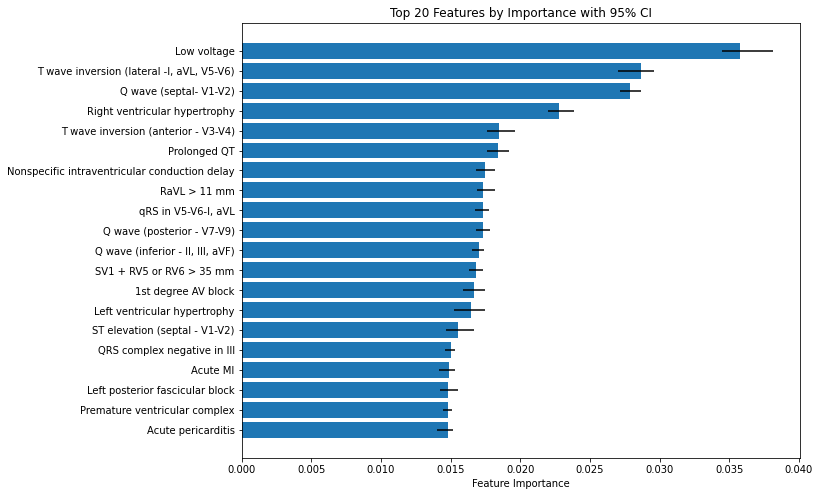

NameError: name 'Y_train' is not defined

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, balanced_accuracy_score
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import linregress

# Predefined seeds for reproducibility
seeds = [42, 0, 7, 13, 21, 25, 31, 37, 51, 57]

# Define feature names based on the number of columns in train_probs
# This should match the number of labels or classes you have
feature_names = [f"feature_{i}" for i in range(train_probs.shape[1])]

# Function to train and evaluate the model for a given seed
def train_and_evaluate(seed):
    X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
        attack_data, attack_labels, test_size=0.2, random_state=seed
    )
    
    class_0_indices = np.where(y_test_attack == 0)[0]
    class_1_indices = np.where(y_test_attack == 1)[0]
    min_class_size = min(len(class_0_indices), len(class_1_indices))
    
    balanced_class_0_indices = np.random.choice(class_0_indices, min_class_size, replace=False)
    balanced_class_1_indices = np.random.choice(class_1_indices, min_class_size, replace=False)
    balanced_indices = np.concatenate([balanced_class_0_indices, balanced_class_1_indices])
    
    X_test_attack_balanced = X_test_attack[balanced_indices]
    y_test_attack_balanced = y_test_attack[balanced_indices]

    attack_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=seed)
    attack_model.fit(X_train_attack, y_train_attack)

    feature_importances = attack_model.feature_importances_

    attack_preds_proba = attack_model.predict_proba(X_test_attack_balanced)[:, 1]
    attack_preds = attack_model.predict(X_test_attack_balanced)

    auc = roc_auc_score(y_test_attack_balanced, attack_preds_proba)
    auprc = average_precision_score(y_test_attack_balanced, attack_preds_proba)
    accuracy = accuracy_score(y_test_attack_balanced, attack_preds)
    balanced_accuracy = balanced_accuracy_score(y_test_attack_balanced, attack_preds)
    f1 = f1_score(y_test_attack_balanced, attack_preds)
    
    return auc, auprc, accuracy, balanced_accuracy, f1, feature_importances

# Run iterations and collect results
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(seed) for seed in tqdm(seeds, desc="Training iterations"))
auc_scores, auprc_scores, accuracy_scores, balanced_accuracy_scores, f1_scores, feature_importances_all = zip(*results)

def mean_and_ci(scores):
    mean_score = np.mean(scores)
    ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
    return mean_score, (ci_lower, ci_upper)

metrics = {
    "AUC": mean_and_ci(auc_scores),
    "AUPRC": mean_and_ci(auprc_scores),
    "Accuracy": mean_and_ci(accuracy_scores),
    "Balanced Accuracy": mean_and_ci(balanced_accuracy_scores),
    "F1 Score": mean_and_ci(f1_scores)
}

for metric, (mean, ci) in metrics.items():
    print(f"{metric} - Mean: {mean:.4f}, 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

# Calculate mean feature importances

feature_importances_all = np.array(feature_importances_all)
mean_importances = np.mean(feature_importances_all, axis=0)
ci_importances = np.percentile(feature_importances_all, [2.5, 97.5], axis=0)
ci_lower = ci_importances[0]
ci_upper = ci_importances[1]

# Get top 20 features based on average importance
top_indices = np.argsort(mean_importances)[-20:][::-1]
top_features = [y_labels[i] for i in top_indices]  # Use new_label_names for labels
top_mean_importances = mean_importances[top_indices]
top_ci_lower = ci_lower[top_indices]
top_ci_upper = ci_upper[top_indices]

# Plot top 20 features with confidence intervals
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_mean_importances, xerr=[top_mean_importances - top_ci_lower, top_ci_upper - top_mean_importances], align='center')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance with 95% CI')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

# Calculate label frequencies in y_train and y_test
train_freq = np.mean(Y_train, axis=0)
test_freq = np.mean(Y_test, axis=0)

# Compute the relative difference in frequency
#relative_diff = (train_freq - test_freq) / (train_freq)

# Scatter plot of relative difference in frequency vs feature importance
#plt.figure(figsize=(10, 6))
#plt.scatter(relative_diff, mean_importances, alpha=0.7, color="b", label="Features")

# Regression line
#slope, intercept, r_value, p_value, std_err = linregress(relative_diff, mean_importances)
#line = slope * relative_diff + intercept
#plt.plot(relative_diff, line, 'r', label=f"Regression line (r={r_value:.2f})")

# Labels and title
#plt.xlabel("Relative Difference in Label Frequency (Train vs Test)")
#plt.ylabel("Average Feature Importance")
#plt.title("Correlation Between Label Frequency Difference and Feature Importance")
#plt.legend()
#plt.show()

save_ssl_privacy(metrics), metrics

In [15]:
def save_sl_privacy(scores_dict, subset):
    label = 'privacy'
    scores = {}
    scores[f'{label}_auroc'] = {'mean': scores_dict['AUC'][0], '95% CI': list(scores_dict['AUC'][1])}
    scores[f'{label}_auprc'] = {'mean': scores_dict['AUPRC'][0], '95% CI': list(scores_dict['AUPRC'][1])}
    scores[f'{label}_acc'] = {'mean': scores_dict['Accuracy'][0], '95% CI': list(scores_dict['Accuracy'][1])}
    scores[f'{label}_bacc'] = {'mean': scores_dict['Balanced Accuracy'][0], '95% CI': list(scores_dict['Balanced Accuracy'][1])}
    scores[f'{label}_f1score'] = {'mean': scores_dict['F1 Score'][0], '95% CI': list(scores_dict['F1 Score'][1])}
    
    scores = format_ci_metrics(scores, {}, [label], metrics=['auroc', 'auprc', 'acc', 'bacc', 'f1score'],)
    results_path = '/media/data1/anolin/for_achille_ssl/for_table'
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f'{subset}_77_labels', f'privacy_{n_perm}_{ratio}_.csv'))
    return scores


save_sl_privacy(
     {'AUC': (0.578416194578245, (0.575926938576351, 0.5817773373812397)), 'AUPRC': (0.5567188449991891, (0.5545273328301821, 0.56000041736794)), 'Accuracy': (0.5100158175954501, (0.5095547142284523, 0.5103799170347778)), 'Balanced Accuracy': (0.5100158175954502, (0.5095547142284523, 0.5103799170347779)), 'F1 Score': (0.6705999359043787, (0.6704011481374901, 0.6707812802103431))}      

,subset='MHI'
)

,Label,Metrics,Mean,95% CI
0,privacy,auroc,57.84,[57.59 - 58.18]
1,privacy,auprc,55.67,[55.45 - 56.00]
2,privacy,acc,51.00,[50.96 - 51.04]
3,privacy,bacc,51.00,[50.96 - 51.04]
4,privacy,f1score,67.06,[67.04 - 67.08]


In [17]:
import numpy as np
import pandas as pd

#np.load('/media/data1/anolin/Y_val_v1.1.npy').shape
#pd.read_csv('/media/data1/ravram/DeepECG_Datasets/val_filtered_echo_v2.csv').shape

#np.load('/media/data1/anolin/for_achille_ssl/AFIB/Y_Afib_filtered_val.npy').shape
pd.read_csv('/media/data1/ravram/DeepECG_Datasets/mhi-lqts-type-train-lite.csv').shape


(287, 6)

In [18]:
n_mhi = 1017719 + 149177 
n_lvef = 88677 + 823
n_afib = 469197 + 68545
n_lqts = 2210 + 531
n_lqts_type = 287 + 47

n_lqts_type, n_lqts, n_lvef, n_afib, n_mhi, 

(334, 2741, 89500, 537742, 1166896)